# DS7333 Spam Email Case Study
#### 02/13/2021
#### Michael Weatherford, Yang Zhang and Tom Gianelle

# Table of contents
1. [Data](#data)
2. [Explortory Data Analysis](#eda)
3. [Initial Analysis](#model1)
4. [Extend Analysis and Tuning](#model2)
5. [Feature Importance](#fi)

## Data <a name="data"></a>

In [1]:
library(caret)
library(MLmetrics)
library(naivebayes)
library(e1071)
library(rpart)
library(randomForest)
library(xgboost)

Warning message:
"package 'caret' was built under R version 3.6.2"
Loading required package: lattice

Loading required package: ggplot2

Warning message:
"package 'MLmetrics' was built under R version 3.6.3"

Attaching package: 'MLmetrics'


The following objects are masked from 'package:caret':

    MAE, RMSE


The following object is masked from 'package:base':

    Recall


Warning message:
"package 'naivebayes' was built under R version 3.6.3"
naivebayes 0.9.7 loaded

Warning message:
"package 'e1071' was built under R version 3.6.2"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [2]:
load("./spamAssassinDerivedDF.rda")
dim(emailDF)

[1] 9348   30

In [3]:
load("./data.rda")
dim(emailDFrp)

[1] 9348   30

### Data Description

| Variable | Type | Description| 
|:---|:---|:---|
| isRe|  logical | TRUE if Re: appears at the start of the subject.
| numLines|  integer | Number of lines in the body of the message
| underscore | integer | TRUE if email address in the From field of the header contains an underscore. 
| subExcCt | integer | Number of exclamation marks
| subQuesCt | integer | Number of question marks 
| numAtt | integer | Number of attachments
| numRec | integer | Number of recipients
| isInReplyTo | logical | TRUE if the In-Reply-To key is present
| subPunc | logical | TRUE if words in the subject have punctuation or numbers 
| multipartText | integer | TRUE if the MIME type is multipart/text
| isPGPsigned | logical | TRUE if the message contains a PGP signature 
| subSpamWords | logical | TRUE if the subject contains one of the words in a spam word vector
| noHost | logical | TRUE if there is no hostname 
| priority | logical | TRUE if a Priority key is present in the header
| perCaps | numeric | Percentage of capitals among all letters
| isYelling | logical | TRUE if the subject is all capital letters.
| isOrigMsg | logical | TRUE if the message body contains the phrase original message
| isWrote | logical | TRUE if the message contains the phrase wrote
| numDlr | numeric | Number of dollar signs in the message body
| sortedRec | logical | TRUE if the recipients’ email addresses are sorted
| hour | numeric | Hour of the day 
| hasImages | logical | TRUE if the message contains images
| perHTML | numeric | Percentage of characters in HTML tags compared with all characters
| subBlanks | numeric | Percentage of blanks in the subject.
| numEnd |logical | TRUE if the email sender’s address 
| forwards | numeric | Number of forward symbols in a line of the body
| isDear | logical | TRUE if the message body contains the word dear
| avgWordLen | numeric | he average length of the words in a message

## EDA <a name="eda"></a>

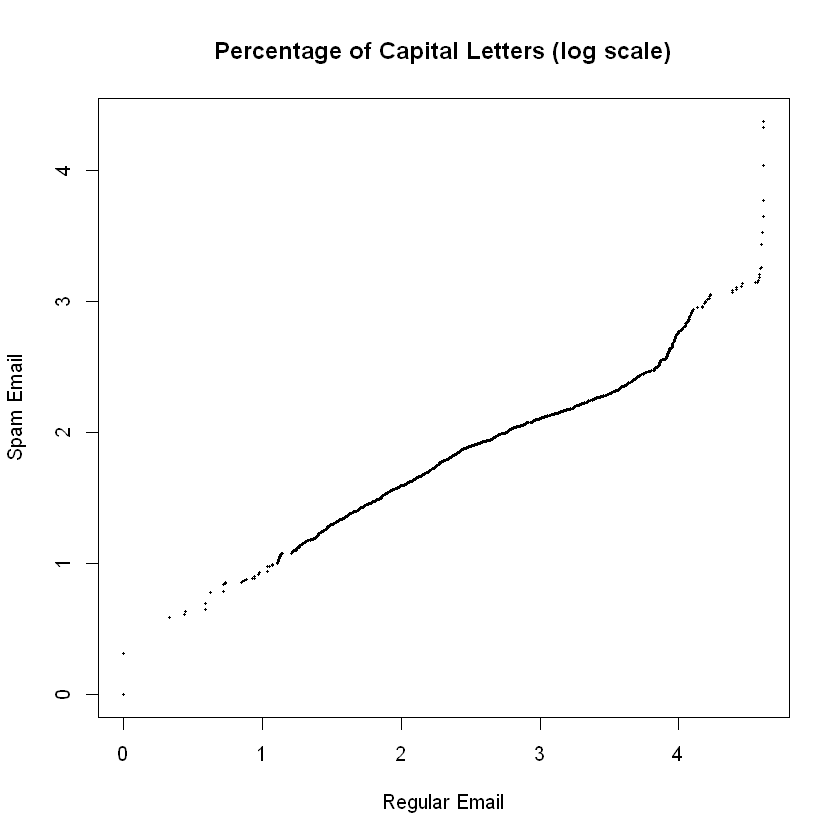

In [5]:
logPerCapsSpam = log(1 + emailDF$perCaps[ emailDF$isSpam ])
logPerCapsHam = log(1 + emailDF$perCaps[ !emailDF$isSpam ])

qqplot(logPerCapsSpam, logPerCapsHam, 
       xlab = "Regular Email", ylab = "Spam Email", 
       main = "Percentage of Capital Letters (log scale)",
       pch = 19, cex = 0.3)

In [11]:
head(emailDF)

,isSpam,isRe,numLines,bodyCharCt,underscore,subExcCt,subQuesCt,numAtt,priority,numRec,...,subBlanks,noHost,numEnd,isYelling,forwards,isOrigMsg,isDear,isWrote,avgWordLen,numDlr
,<lgl>,<lgl>,<int>,<int>,<lgl>,<int>,<int>,<dbl>,<lgl>,<int>,...,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<int>
.//messages2/easy_ham1,FALSE,TRUE,50,1554,FALSE,0,0,0,FALSE,2,...,12.50000,FALSE,FALSE,FALSE,0.000000,FALSE,FALSE,FALSE,4.376623,3
.//messages2/easy_ham2,FALSE,FALSE,26,873,FALSE,0,0,0,FALSE,1,...,8.00000,FALSE,FALSE,FALSE,0.000000,FALSE,FALSE,FALSE,4.555556,0
.//messages2/easy_ham3,FALSE,FALSE,38,1713,FALSE,0,0,0,FALSE,1,...,8.00000,FALSE,FALSE,FALSE,0.000000,FALSE,FALSE,FALSE,4.817164,0
.//messages2/easy_ham4,FALSE,FALSE,32,1095,FALSE,0,0,0,FALSE,0,...,18.91892,FALSE,FALSE,FALSE,3.125000,FALSE,FALSE,FALSE,4.714286,0
.//messages2/easy_ham5,FALSE,TRUE,31,1021,FALSE,0,0,0,FALSE,1,...,15.21739,FALSE,FALSE,FALSE,6.451613,FALSE,FALSE,FALSE,4.234940,0
.//messages2/easy_ham6,FALSE,TRUE,25,718,FALSE,0,0,0,FALSE,1,...,15.21739,FALSE,FALSE,FALSE,12.000000,FALSE,FALSE,FALSE,3.956897,0


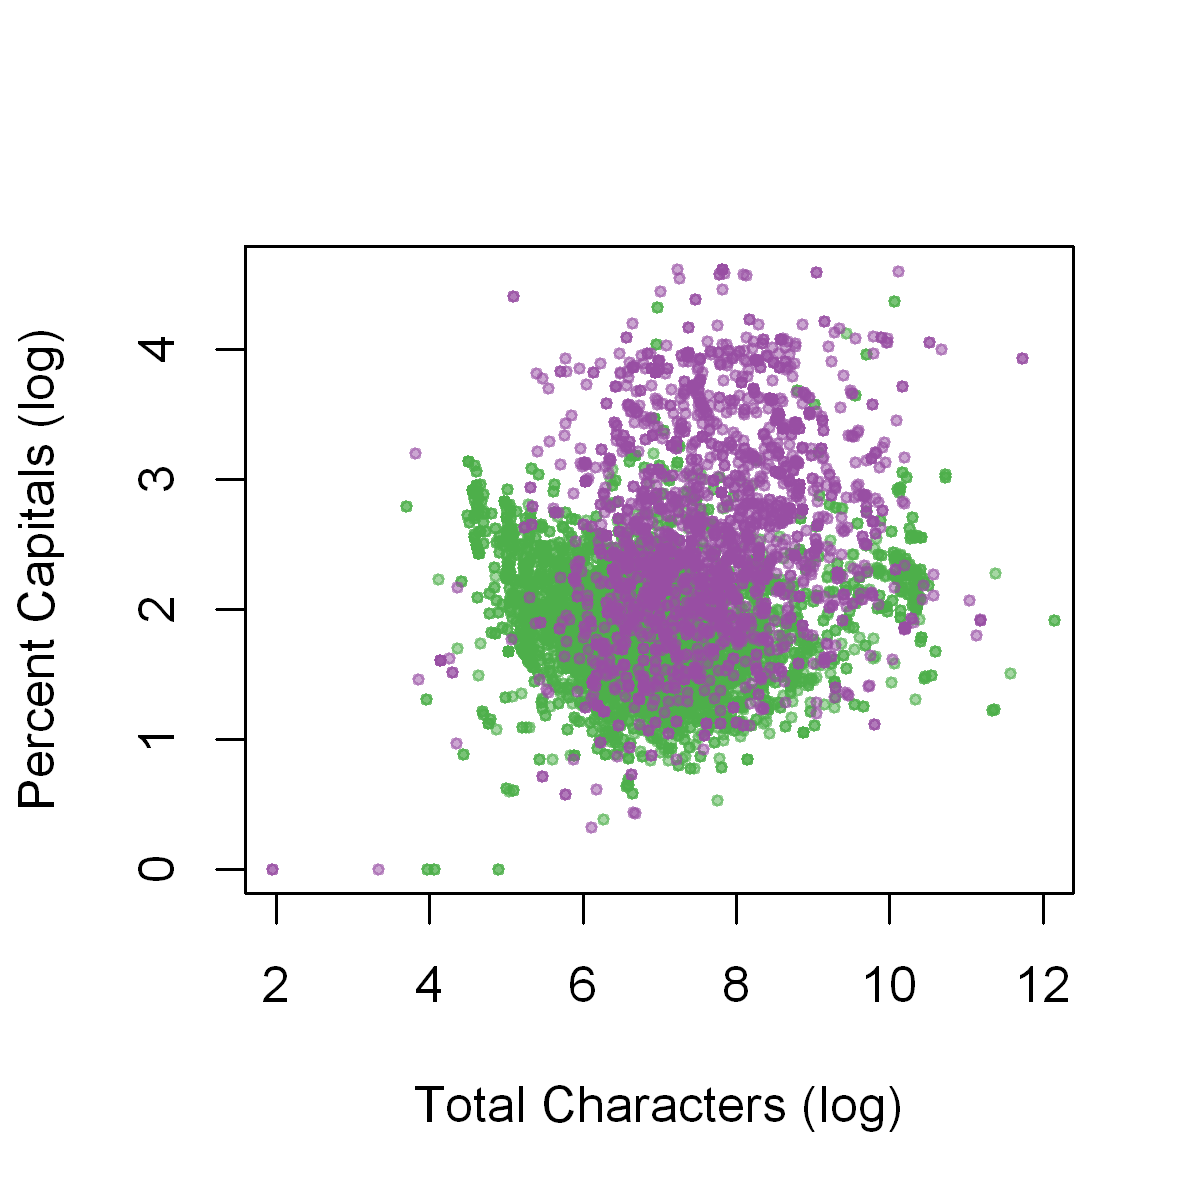

In [77]:
options(repr.plot.width=4, repr.plot.height=4)
colI = c("#4DAF4A80", "#984EA380")
logBodyCharCt = log(1 + emailDF$bodyCharCt)
logPerCaps = log(1 + emailDF$perCaps)
plot(logPerCaps ~ logBodyCharCt, xlab = "Total Characters (log)",
     ylab = "Percent Capitals (log)",
     col = colI[1 + emailDF$isSpam],
     xlim = c(2,12), pch = 19, cex = 0.5)

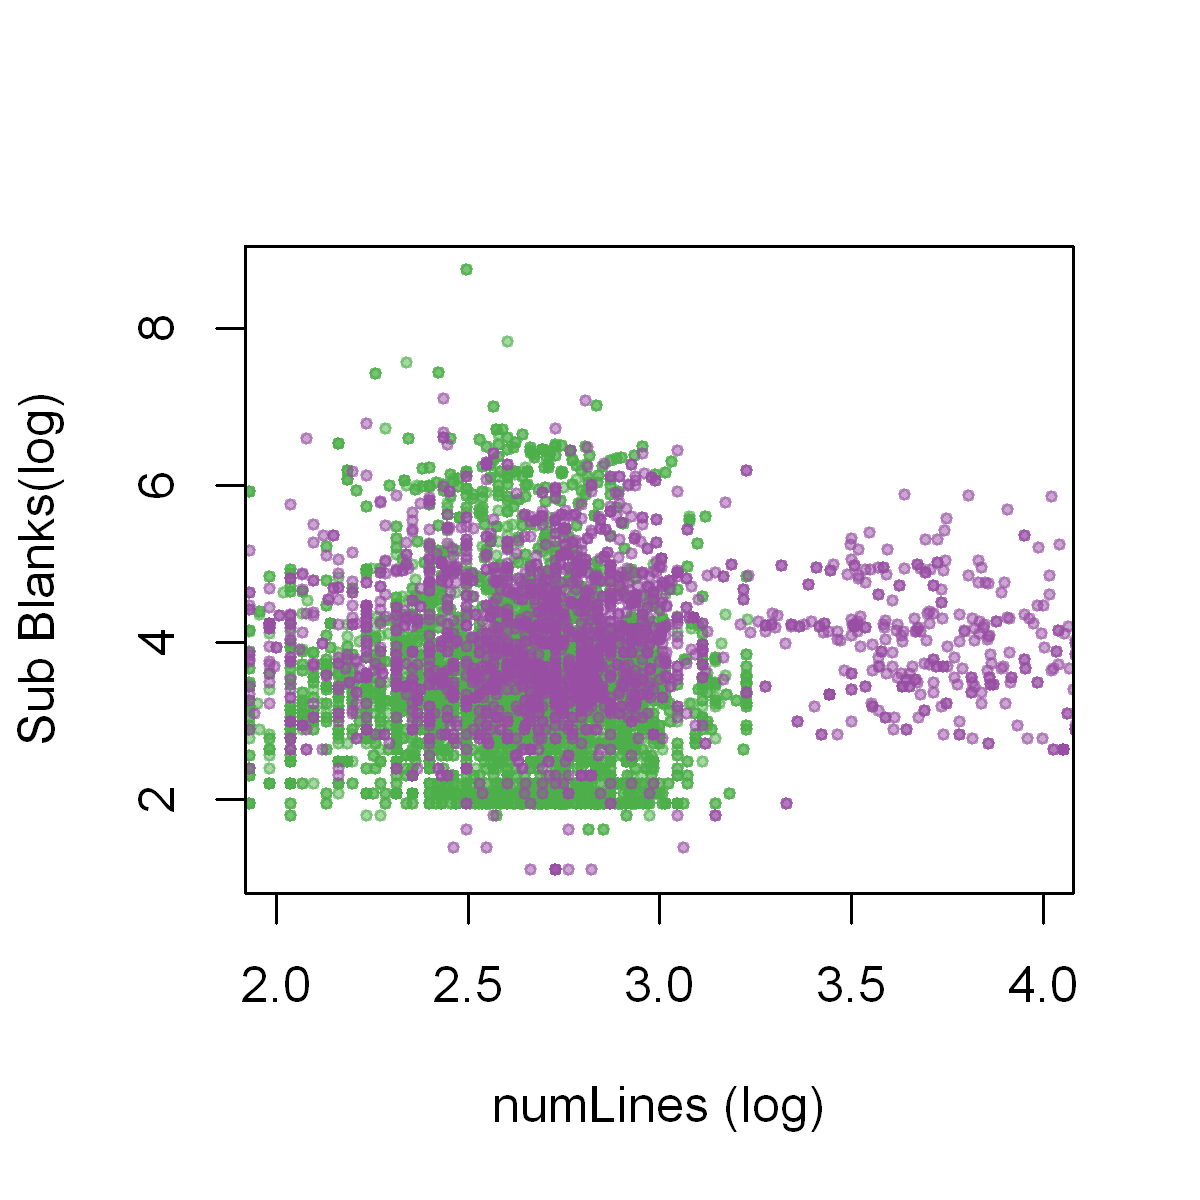

In [79]:
options(repr.plot.width=4, repr.plot.height=4)
colI = c("#4DAF4A80", "#984EA380")
logA = log(1 + emailDF$numLines)
logB = log(1 + emailDF$subBlanks)
plot(logA ~ logB, xlab = "numLines (log)",
     ylab = "Sub Blanks(log)",
     col = colI[1 + emailDF$isSpam],
     xlim = c(2,4), pch = 19, cex = 0.5)

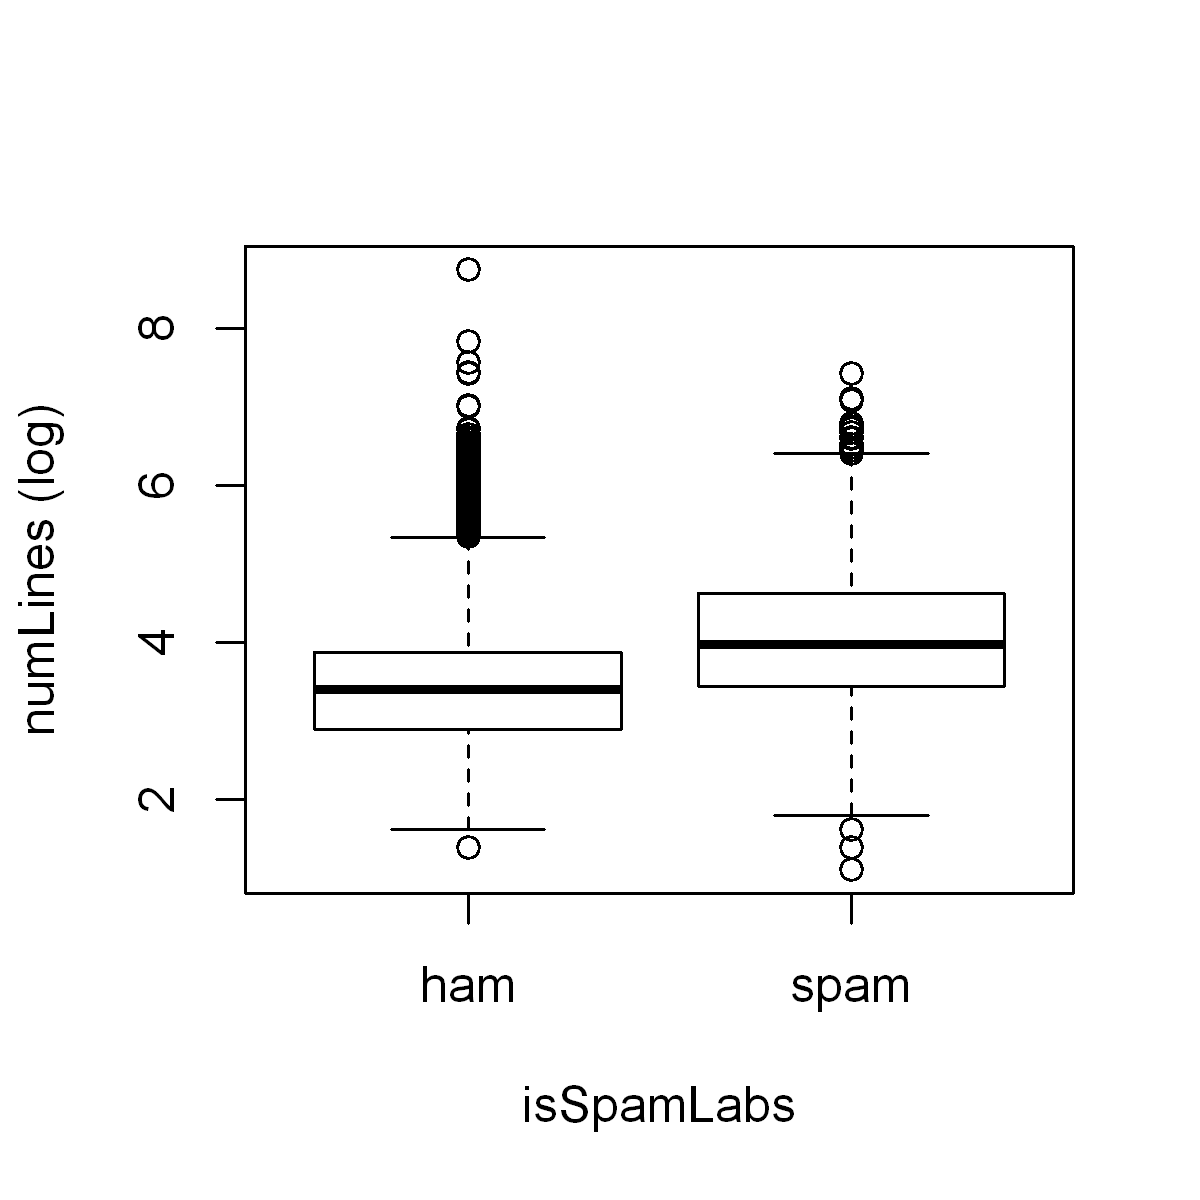

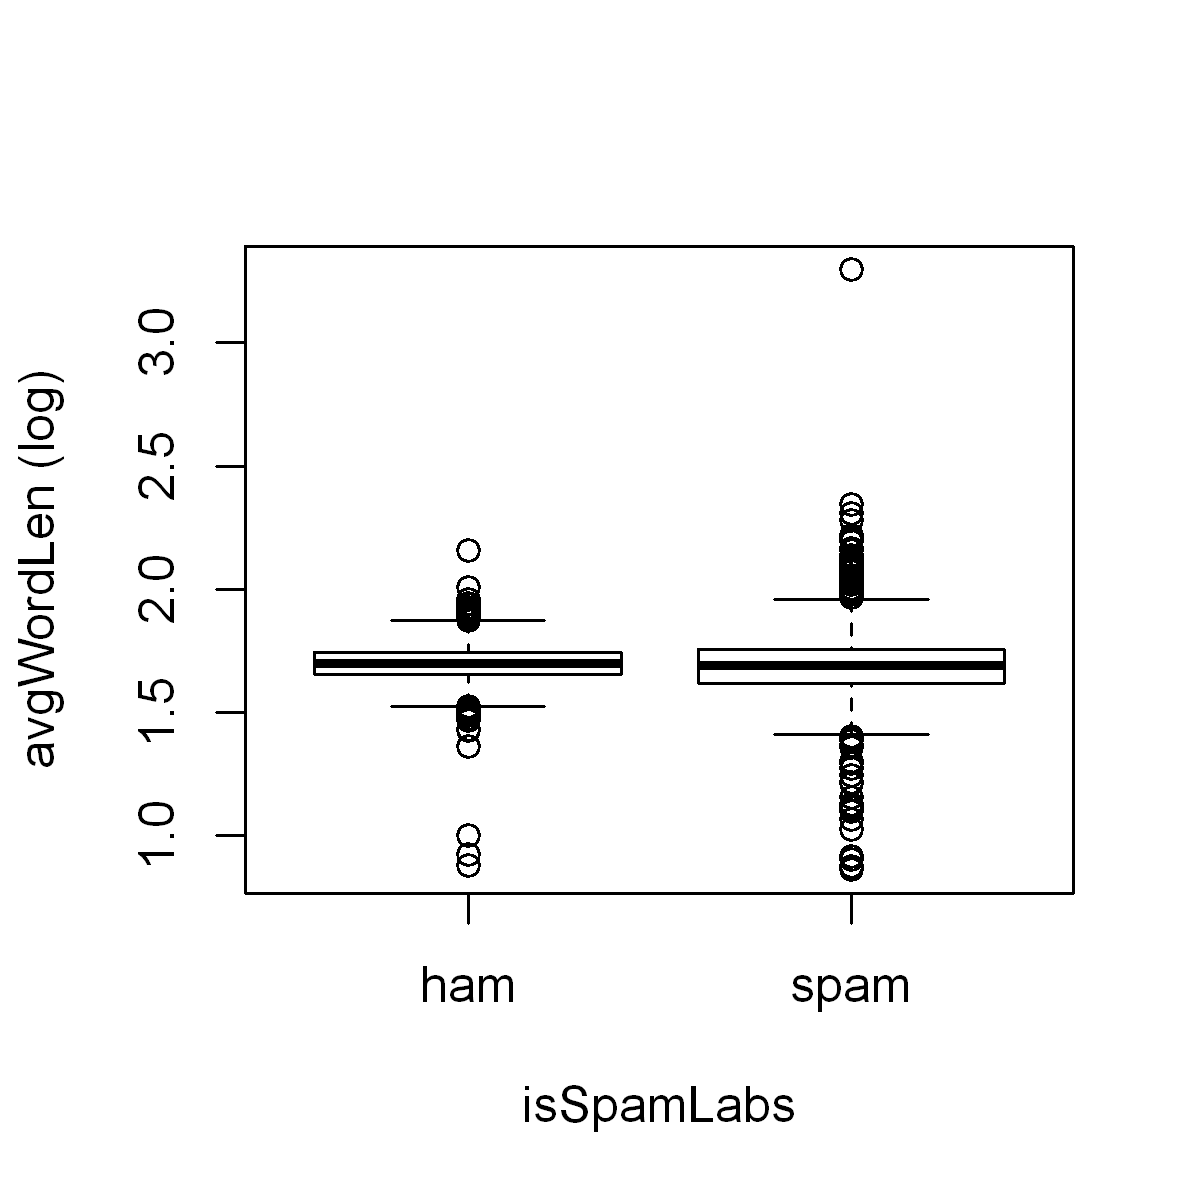

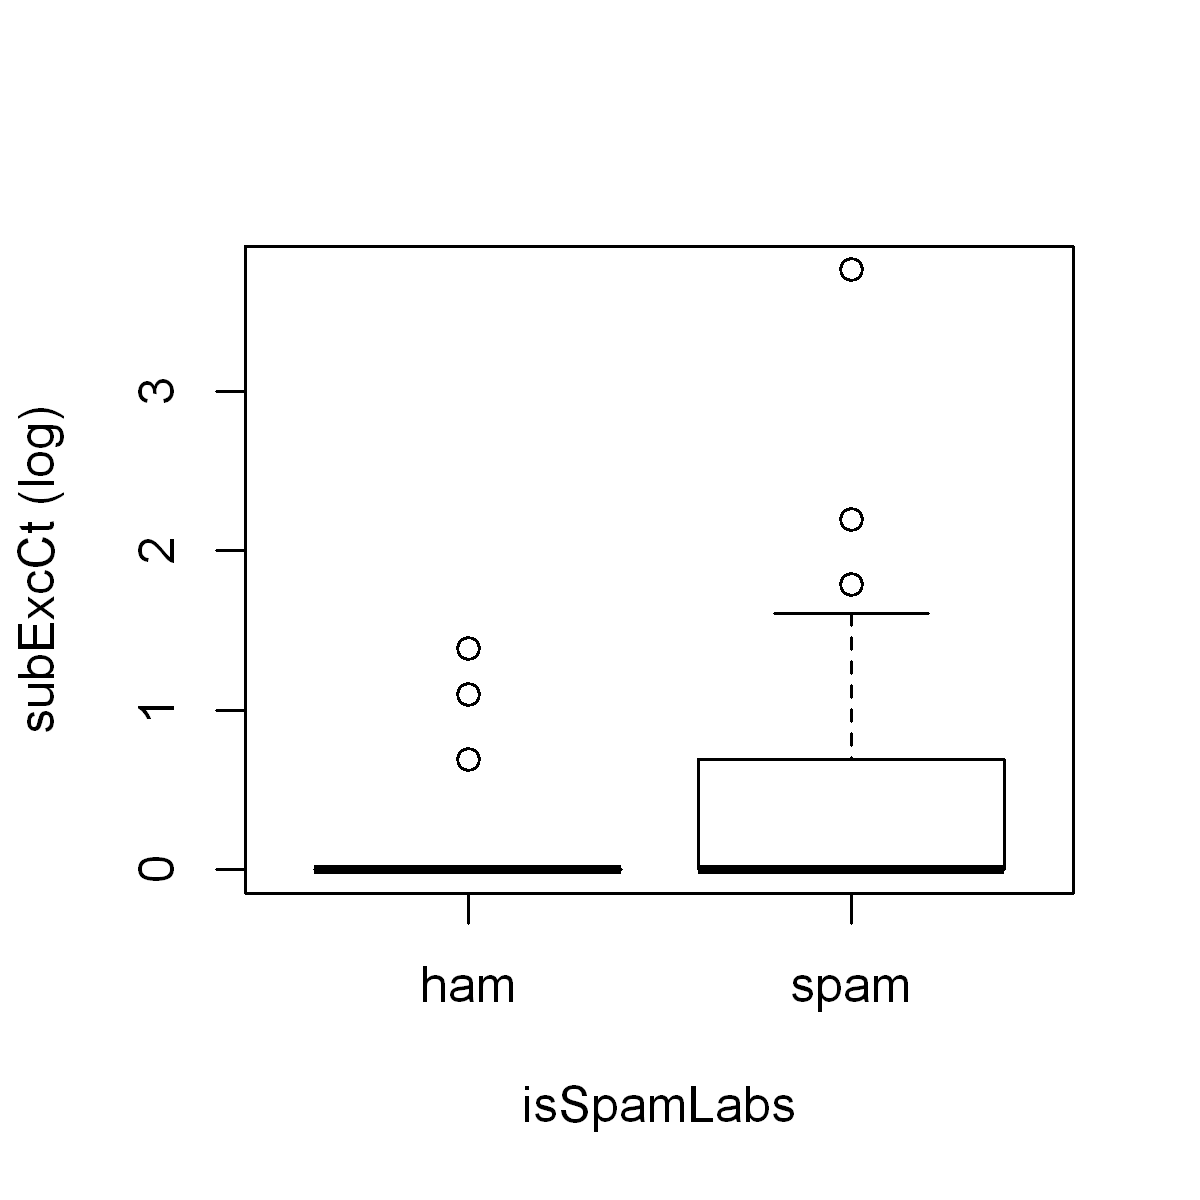

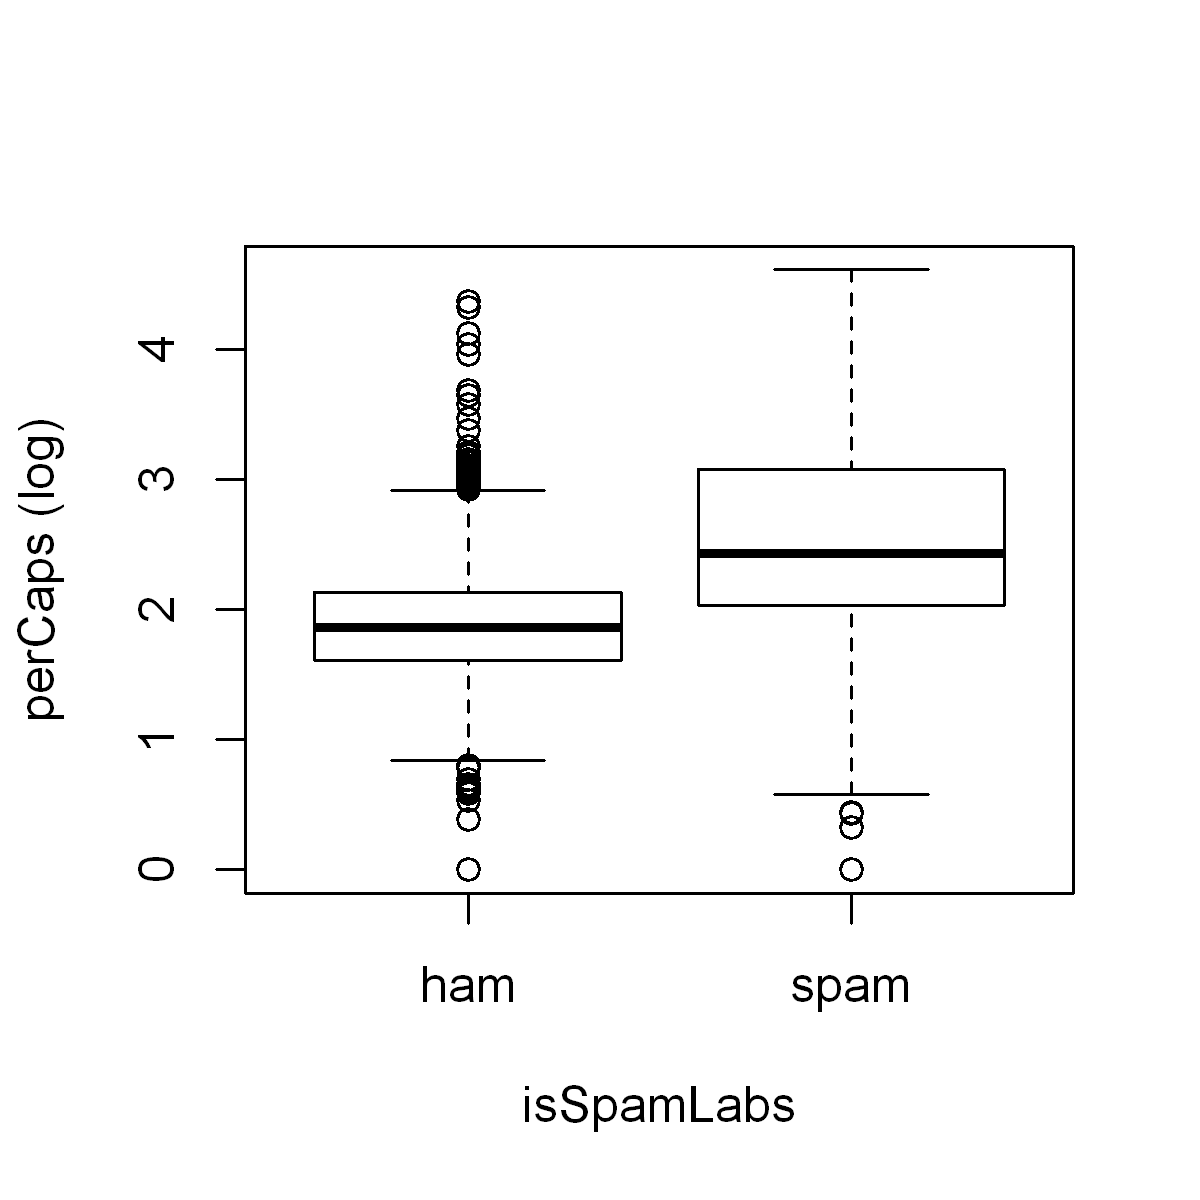

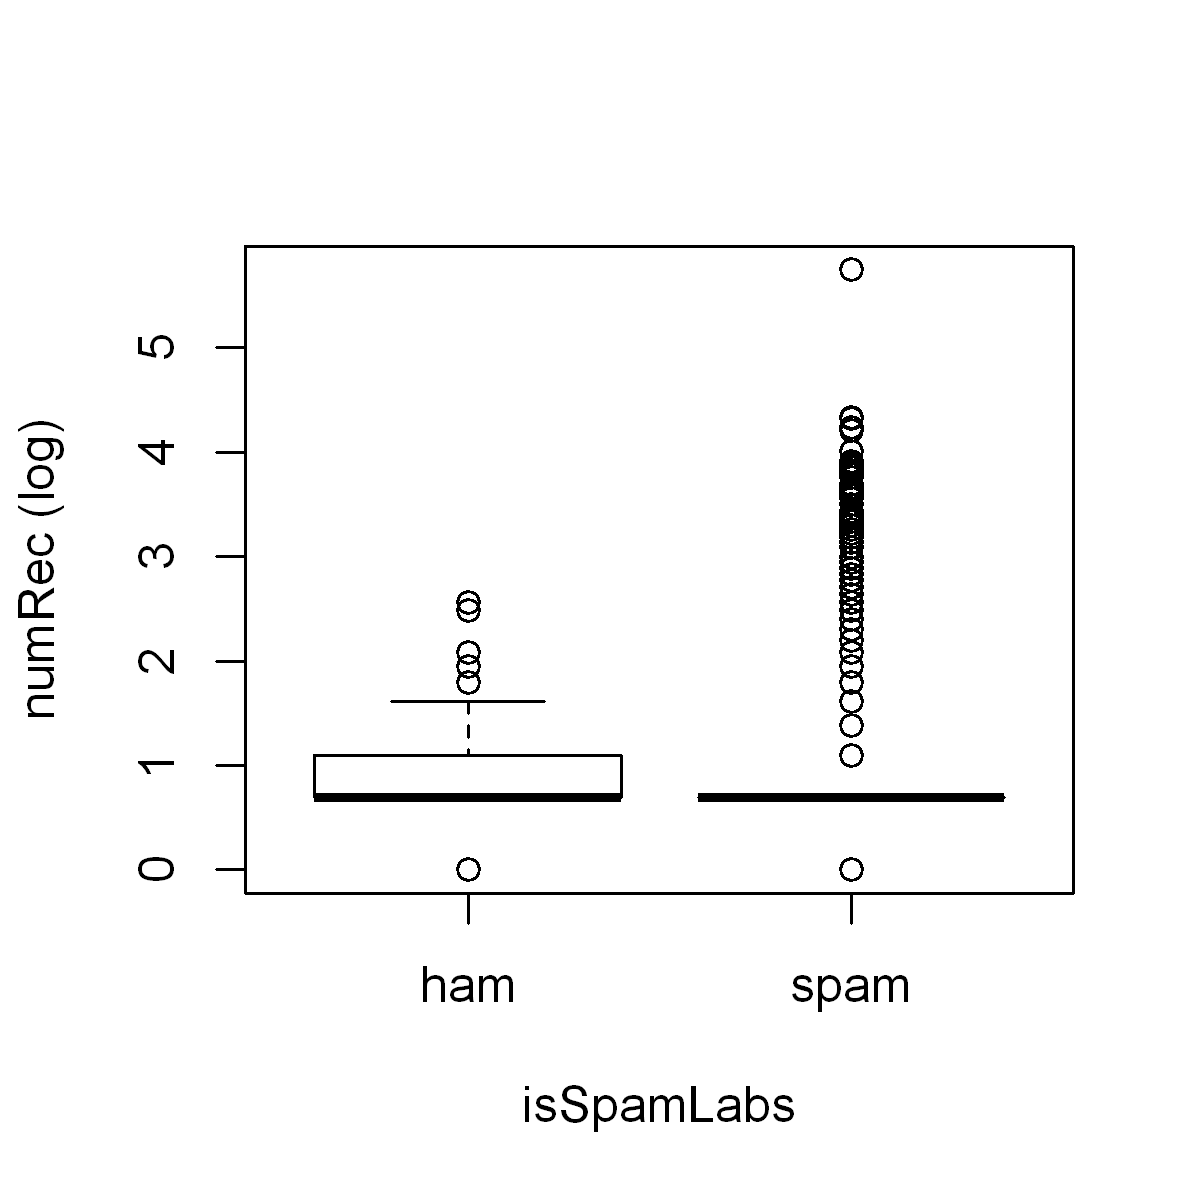

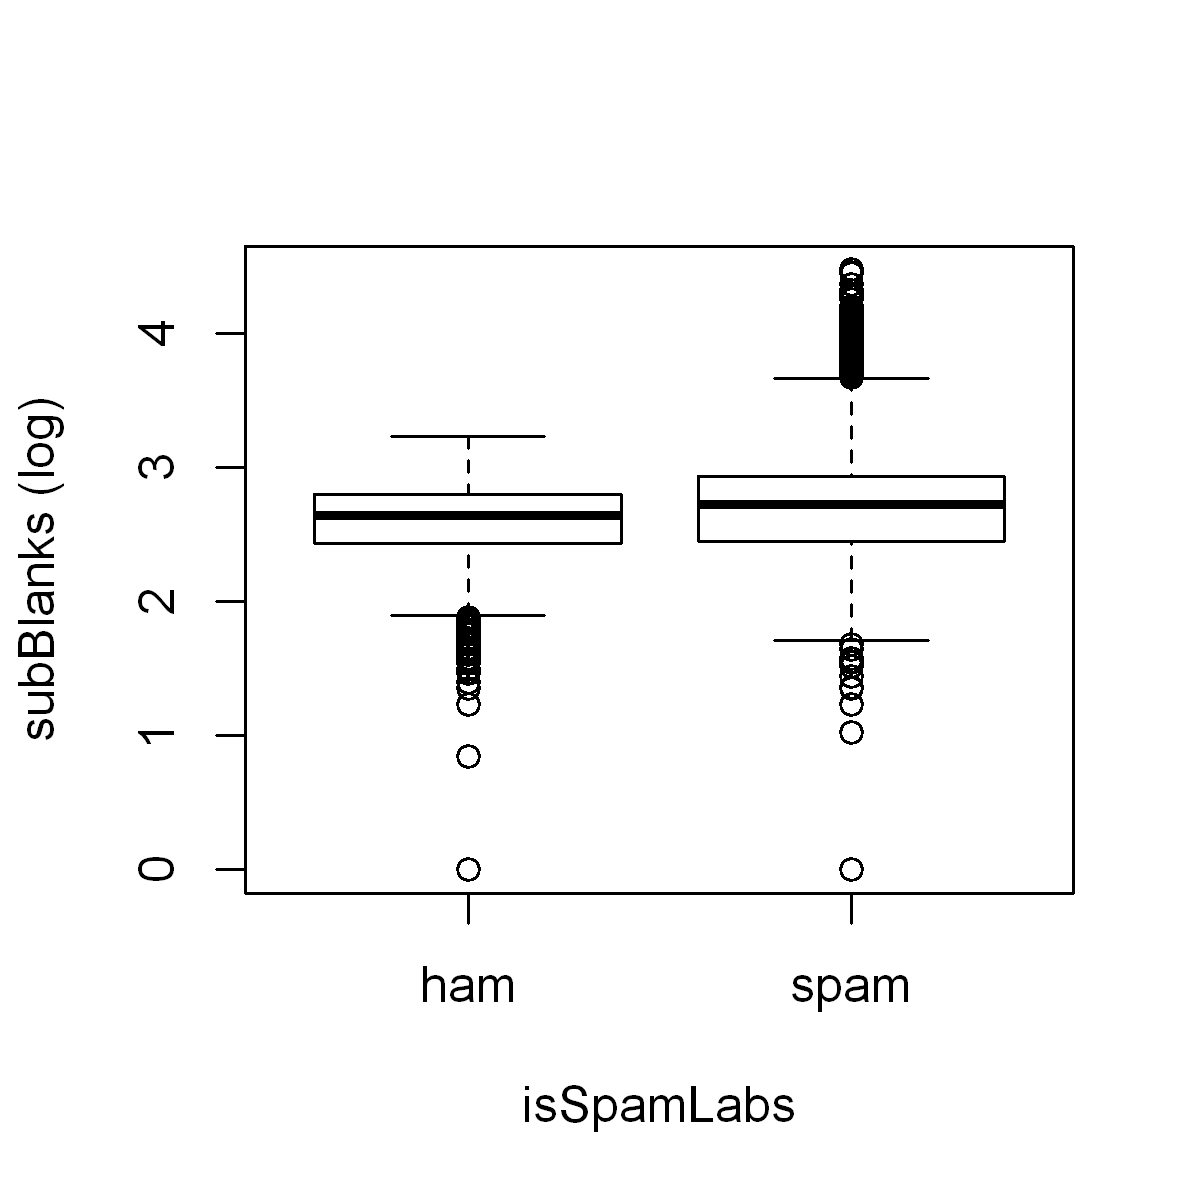

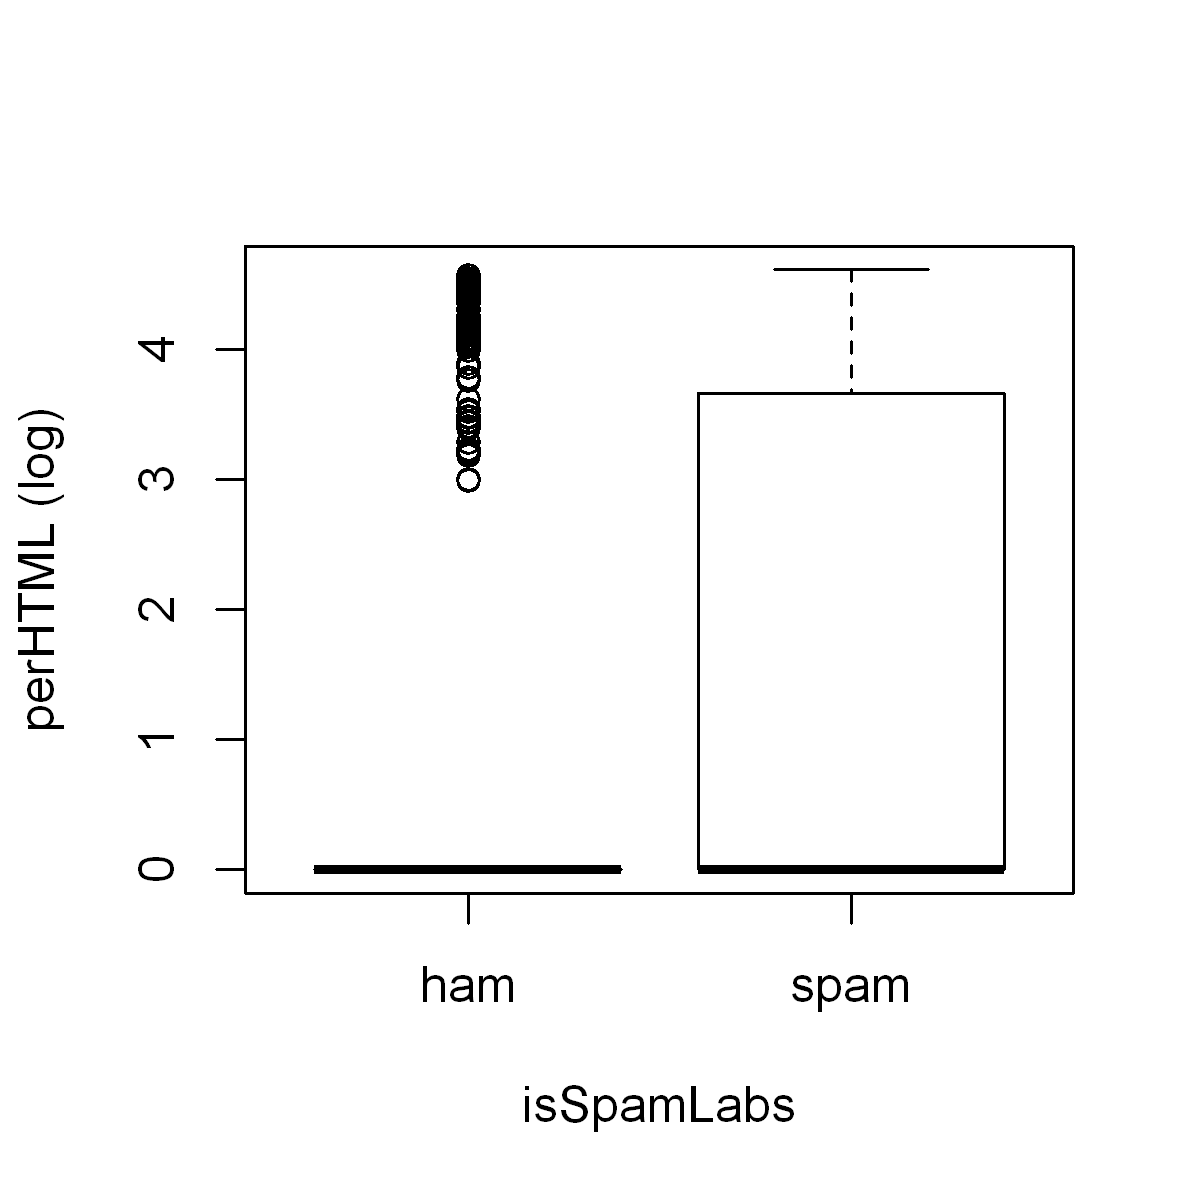

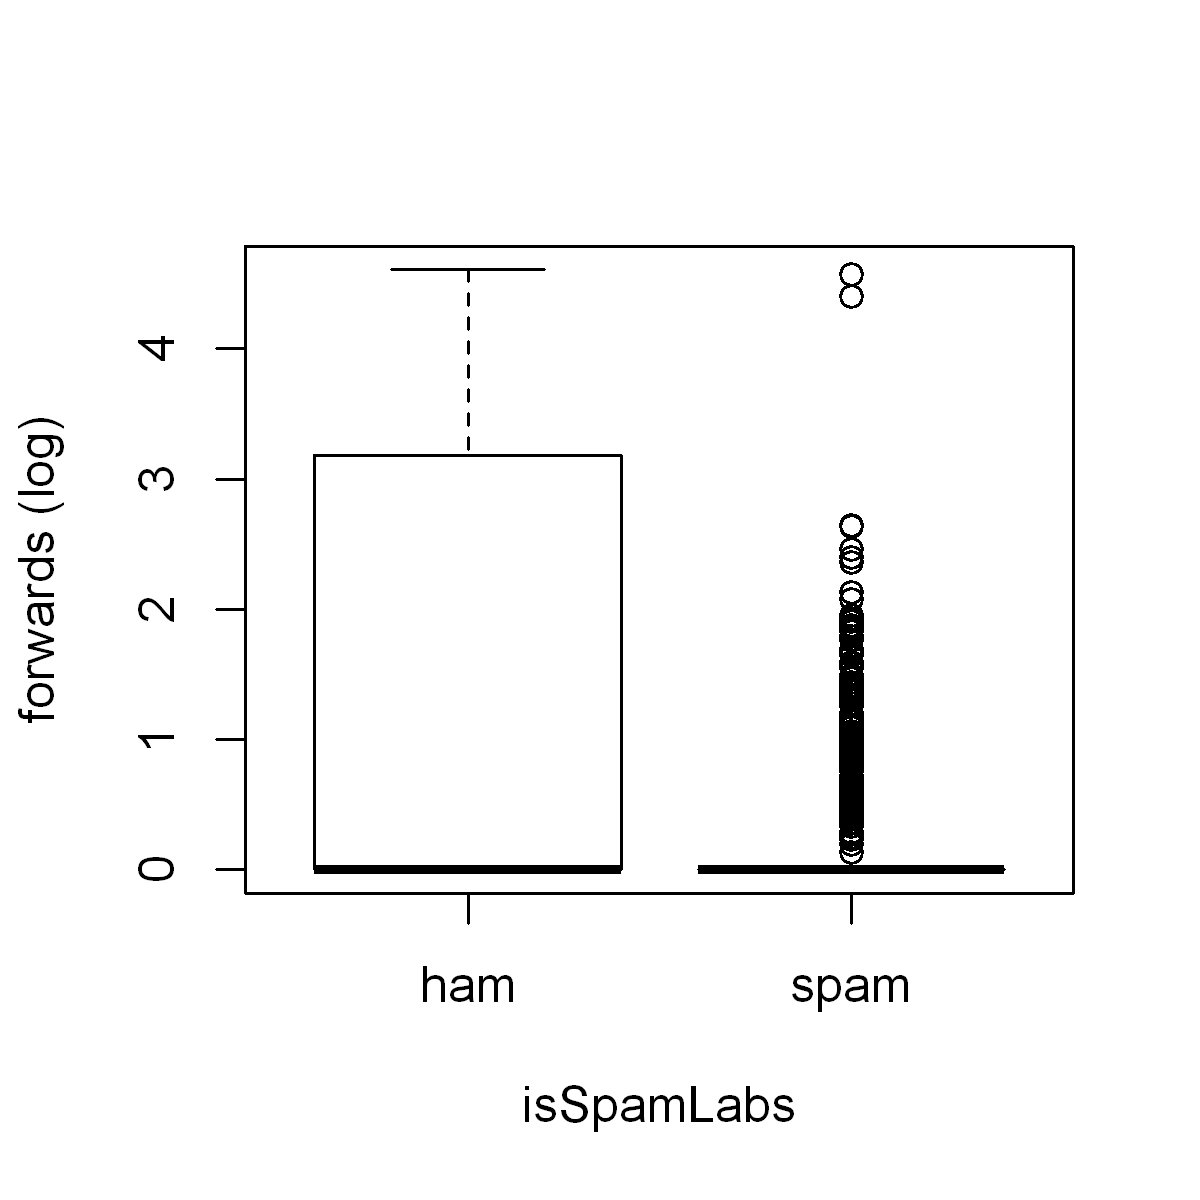

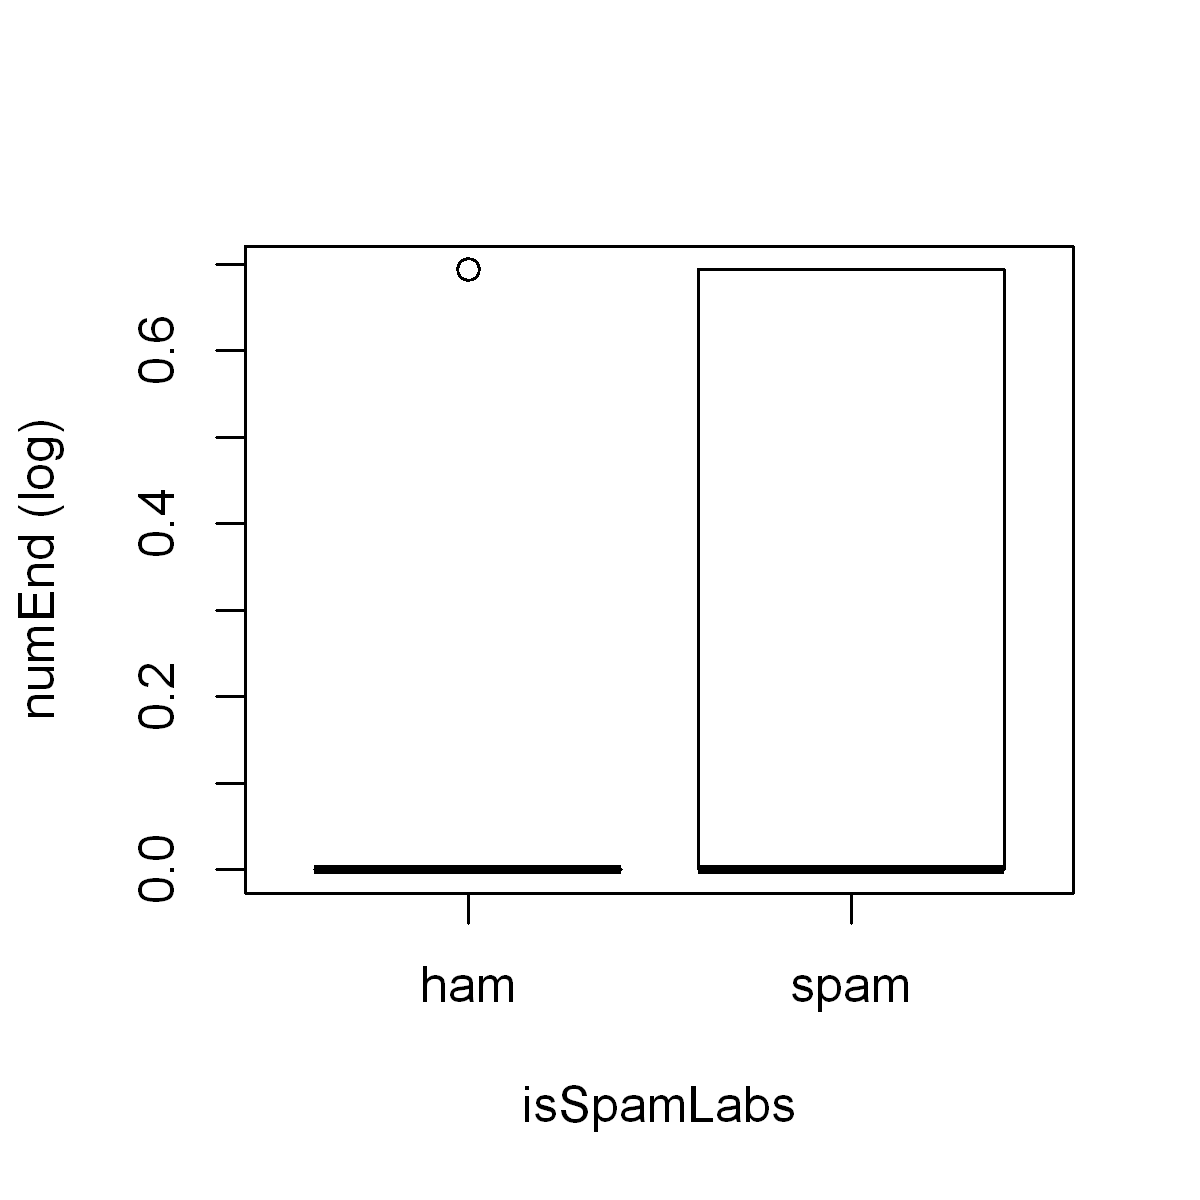

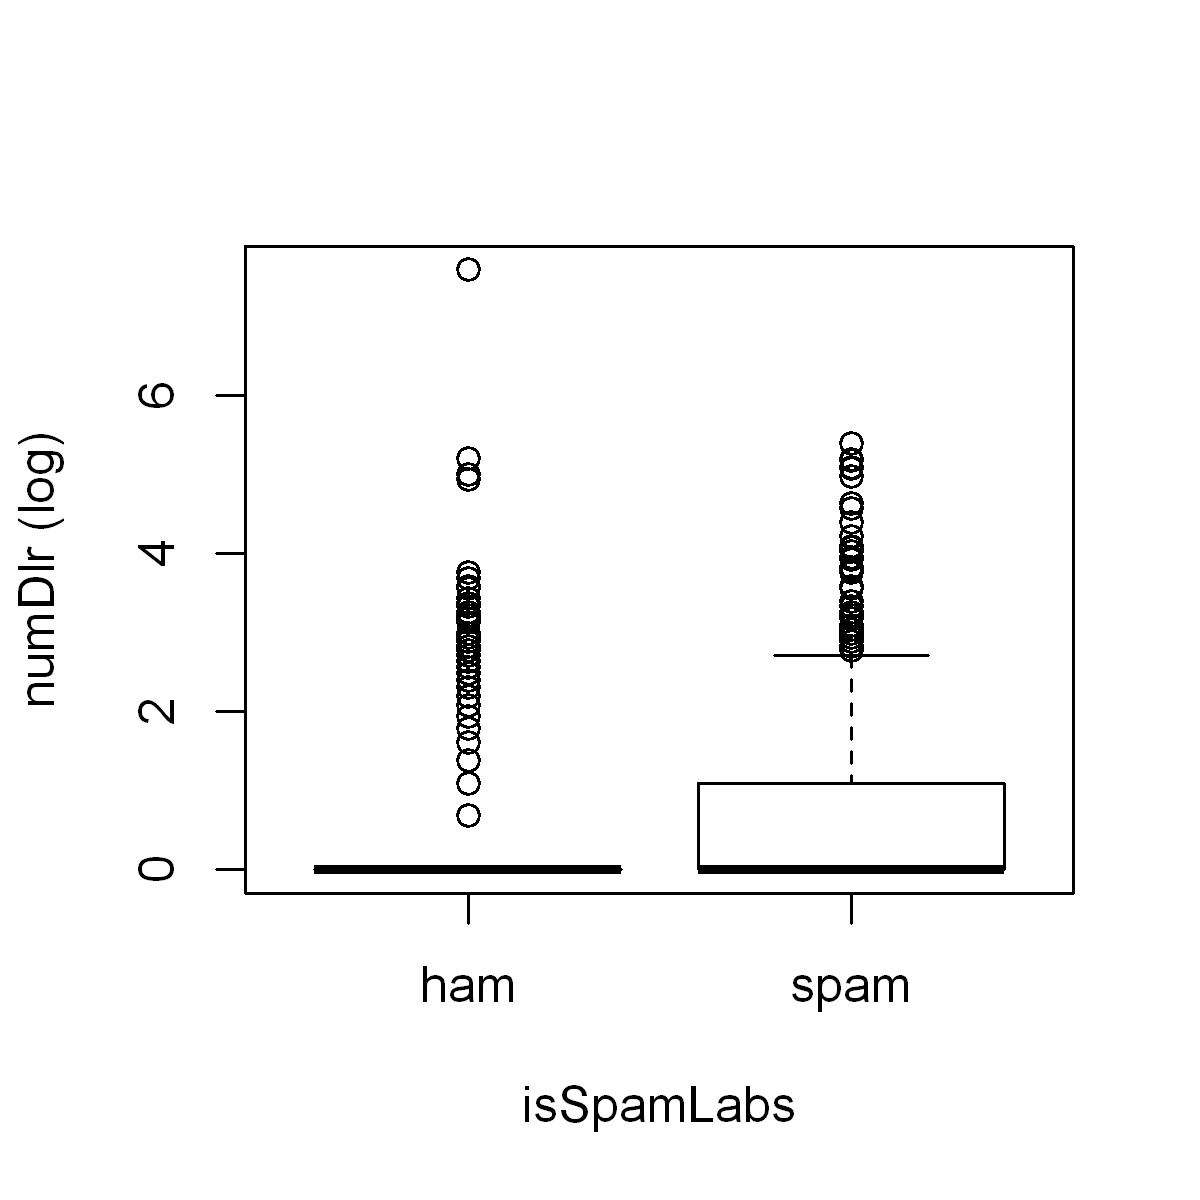

In [76]:
options(repr.plot.width=4, repr.plot.height=4,repr.plot.res = 300)
percent = emailDF$numLines
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "numLines (log)")

percent = emailDF$avgWordLen
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "avgWordLen (log)")

percent = emailDF$subExcCt
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "subExcCt (log)")

percent = emailDF$perCaps
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "perCaps (log)")

percent = emailDF$numRec
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "numRec (log)")

percent = emailDF$subBlanks
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "subBlanks (log)")

percent = emailDF$perHTML
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "perHTML (log)")

percent = emailDF$forwards
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "forwards (log)")

percent = emailDF$numEnd
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "numEnd (log)")

percent = emailDF$numDlr
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "numDlr (log)")

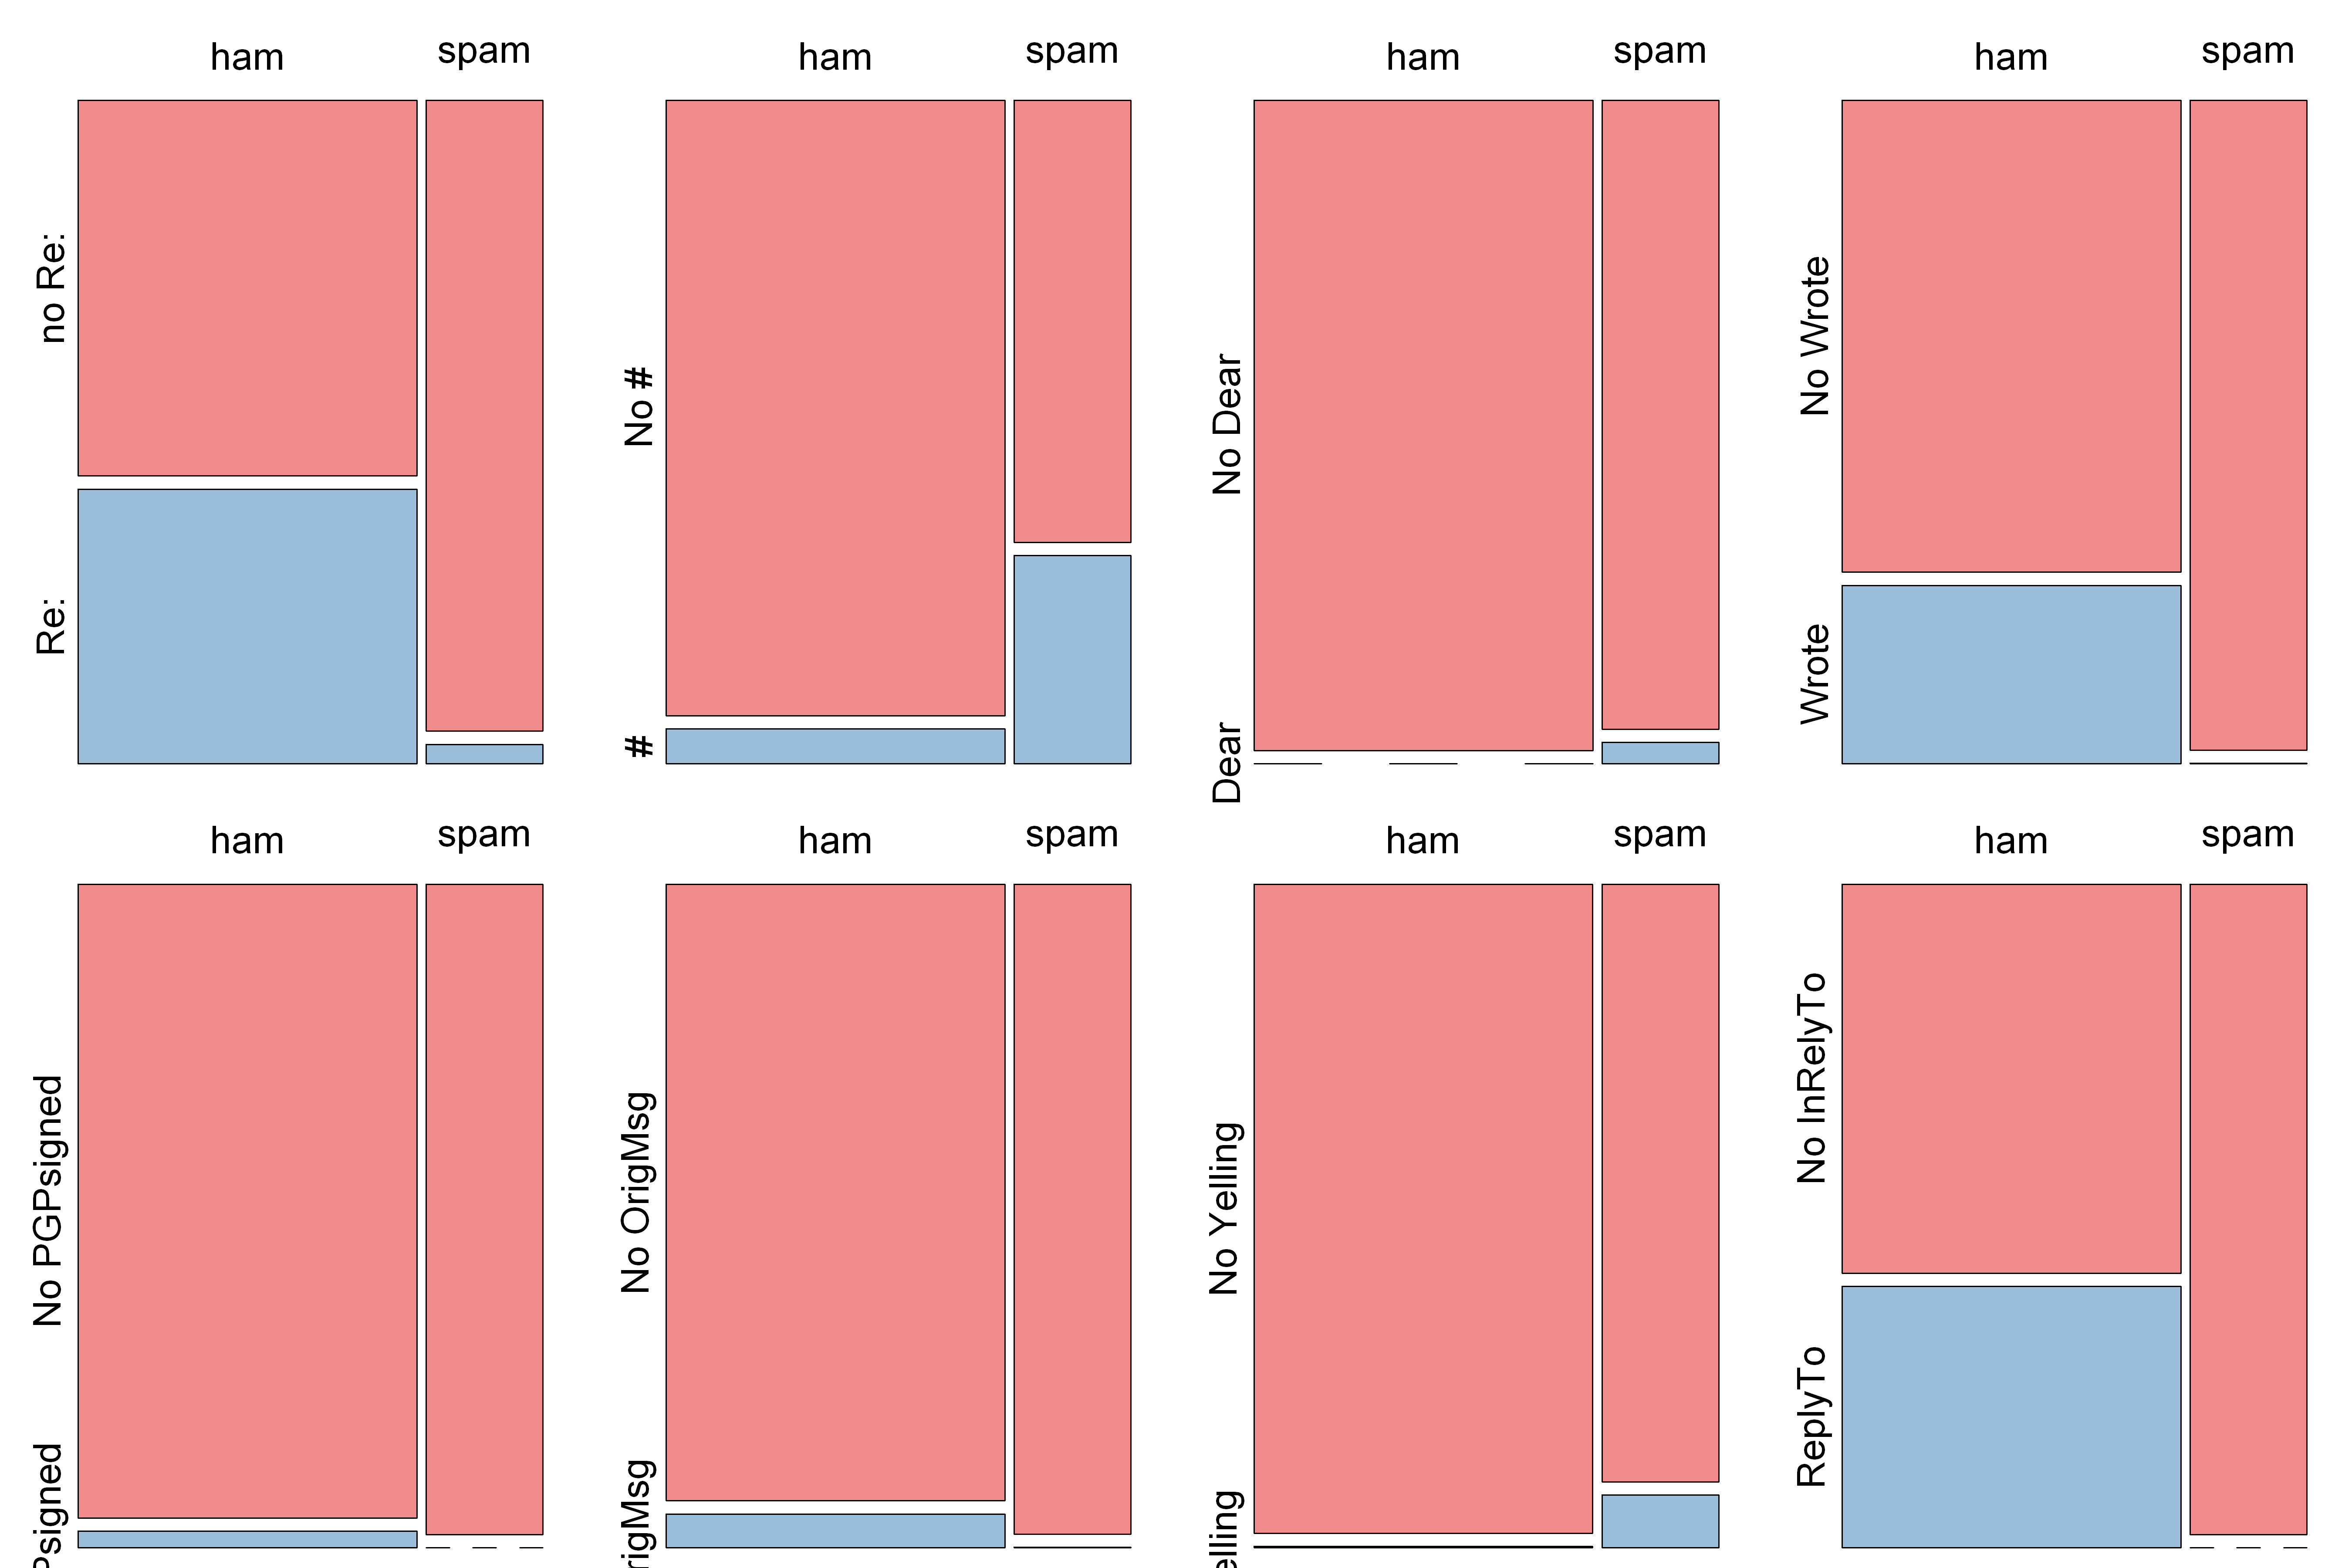

In [87]:
options(repr.plot.width=18, repr.plot.height=12,repr.plot.res = 300)
oldPar = par(mfrow = c(2, 4), mar = c(1,1,1,1))

colM = c("#E41A1C80", "#377EB880")
isRe = factor(emailDF$isRe, labels = c("no Re:", "Re:"))
mosaicplot(table(isSpamLabs, isRe), main = "",
           xlab = "", ylab = "", cex.axis = 2.66, color = colM)

fromNE = factor(emailDF$numEnd, labels = c("No #", "#"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

fromNE = factor(emailDF$isDear, labels = c("No Dear", "Dear"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

fromNE = factor(emailDF$isWrote, labels = c("No Wrote", "Wrote"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

fromNE = factor(emailDF$isPGPsigned, labels = c("No PGPsigned", "PGPsigned"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

fromNE = factor(emailDF$isOrigMsg, labels = c("No OrigMsg", "OrigMsg"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

fromNE = factor(emailDF$isYelling, labels = c("No Yelling", "Yelling"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

fromNE = factor(emailDF$isInReplyTo, labels = c("No InRelyTo", "ReplyTo"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,cex.axis = 2.66,
           main = "", xlab="", ylab = "")

par(oldPar)

## Initial Analysis <a name="model1"></a>

In [10]:
numSpam = 2397
numHam = 6951

In [11]:
set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testDF = 
  rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF =
  rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")

F    T 
2167  150

[1] 0.06473889

[1] 0.1864831

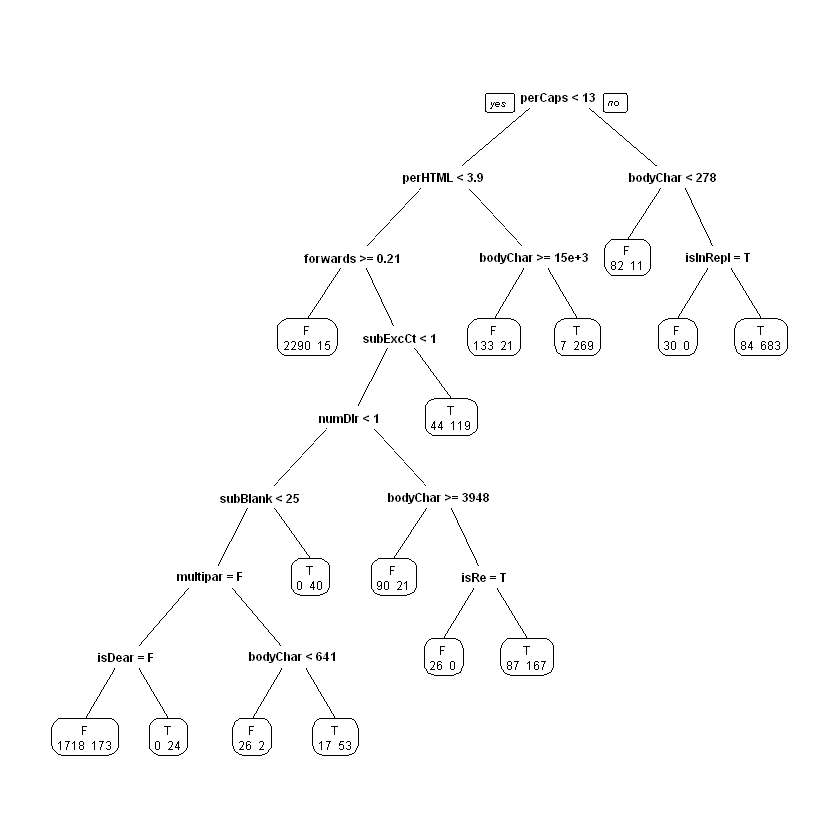

In [6]:
library(rpart.plot)

prp(rpartFit, extra = 1)

library(rpart.plot)
#pdf("SPAM_rpartTree.pdf", width = 7, height = 7)

prp(rpartFit, extra = 1)
#dev.off()

predictions = predict(rpartFit, 
       newdata = testDF[, names(testDF) != "isSpam"],
       type = "class")
 
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

sum(predsForHam == "T") / length(predsForHam)

predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

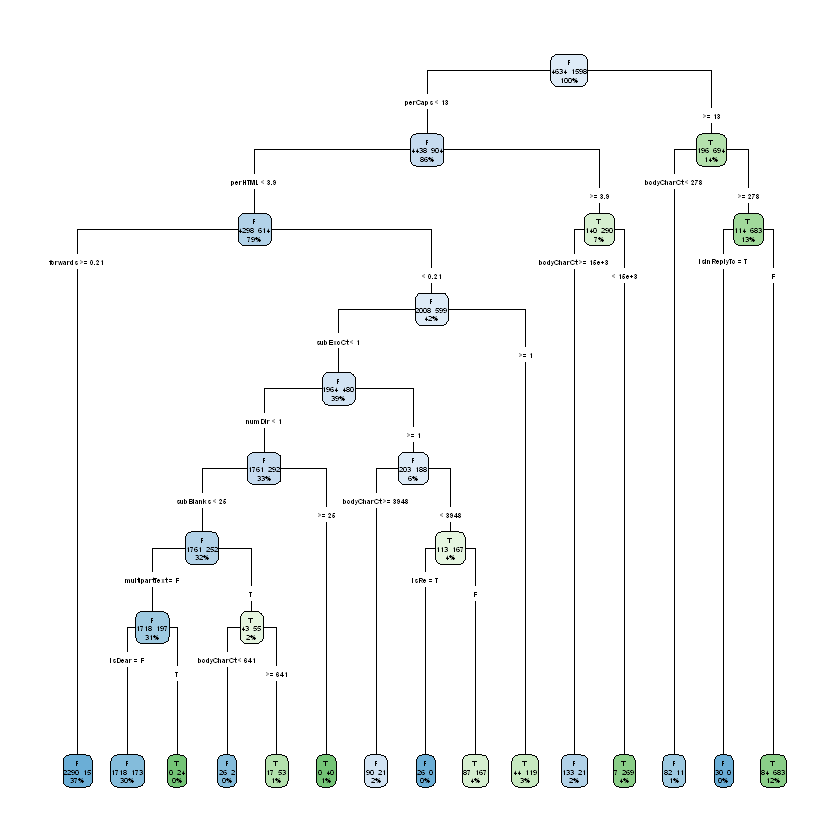

In [7]:
rpart.plot(rpartFit, type = 4, extra = 101)

In [8]:
fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })


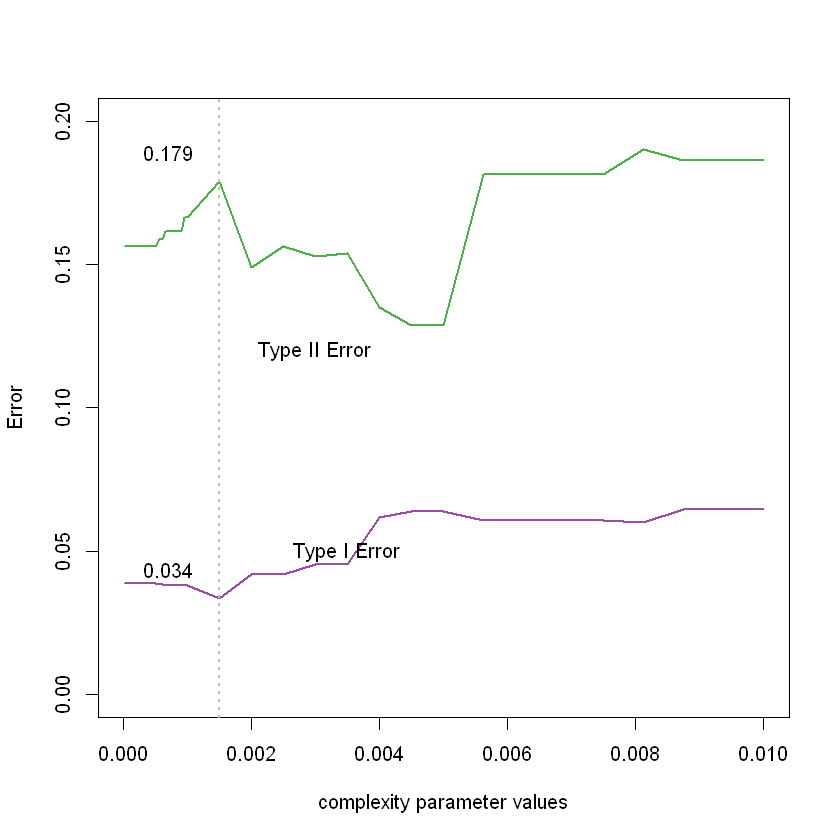

In [10]:
#pdf("SPAM_rpartTypeIandII.pdf", width = 8, height = 7)
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.01), 
     ylab="Error", xlab="complexity parameter values")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)

text(x =c(0.003, 0.0035), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))

#dev.off()

## Extend Analysis and Tuning <a name="model2"></a>

In [4]:
setupRnum = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.numeric(x)
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFnum = setupRnum(emailDF)

emailDFnum[is.na(emailDFnum)]<-0

In [5]:
library(MLmetrics)
f1 <- function(data, lev = NULL, model = NULL) {
  f1_val <- F1_Score(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  p <- Precision(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  r <- Recall(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  fp <-sum(data$pred==0 & data$obs==1)/length(data$pred)  
 
  fn <-sum(data$pred==1 & data$obs==0)/length(data$pred)
    c(F1 = f1_val,
    prec = p,
    rec = r,
    Type_I_err=fp,
    Type_II_err=fn
   )
}

In [35]:
library(naivebayes)
library(e1071)
nb_grid<-expand.grid(laplace=c(0,0.1,0.3,0.5,1), usekernel=c(T,F), adjust=c(T,F))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_nb<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='naive_bayes',tuneGrid = nb_grid)
model_nb

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."
Warning message:
"model fit failed for Fold1: laplace=0.0, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"
Warning message:
"model fit failed for Fold1: laplace=0.1, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"
Warning message:
"model fit failed for Fold1: laplace=0.3, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"
Warning message:
"model fit failed for Fold1: laplace=0.5, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"
Warning message:
"model fit failed for Fold1: laplace=1.0, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"
Warning message:
"model fit failed for Fold2: laplace=0.

Naive Bayes 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  laplace  usekernel  adjust  F1         prec       rec        Type_I_err
  0.0      FALSE      FALSE   0.9225032  0.9344182  0.9112358  0.04781772
  0.0      FALSE       TRUE   0.9225032  0.9344182  0.9112358  0.04781772
  0.0       TRUE      FALSE         NaN        NaN        NaN         NaN
  0.0       TRUE       TRUE   0.8912869  0.8046227  0.9989930  0.18057338
  0.1      FALSE      FALSE   0.9225032  0.9344182  0.9112358  0.04781772
  0.1      FALSE       TRUE   0.9225032  0.9344182  0.9112358  0.04781772
  0.1       TRUE      FALSE         NaN        NaN        NaN         NaN
  0.1       TRUE       TRUE   0.8912869  0.8046227  0.9989930  0.18057338
  0.3      FALSE      FALSE   0.9225032  0.9344182  0.9112358  0.04781772
  0.3      FALSE       TRUE   0.9225032  0.93441

Best F1 score: 0.92

In [36]:
val<-seq(from = 0, to=0.01, by=0.0005)
library(rpart)
cart_grid<-expand.grid(cp=val)
train_control<-trainControl(method="cv", number =5, savePredictions = 'final',summaryFunction = f1)
model_rpart<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='rpart',tuneGrid = cart_grid)
model_rpart

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


CART 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7479, 7478, 7479, 7479, 7477 
Resampling results across tuning parameters:

  cp      F1         prec       rec        Type_I_err  Type_II_err
  0.0000  0.9597147  0.9563466  0.9631720  0.03273500  0.02738455 
  0.0005  0.9598644  0.9563627  0.9634598  0.03273506  0.02717064 
  0.0010  0.9602523  0.9558461  0.9647543  0.03316207  0.02620842 
  0.0015  0.9594768  0.9566805  0.9623074  0.03241289  0.02802780 
  0.0020  0.9579346  0.9592117  0.9566972  0.03027282  0.03219984 
  0.0025  0.9563914  0.9565598  0.9562654  0.03230565  0.03252098 
  0.0030  0.9558393  0.9555804  0.9561217  0.03305471  0.03262776 
  0.0035  0.9554397  0.9559459  0.9549706  0.03273369  0.03348384 
  0.0040  0.9528163  0.9556412  0.9500803  0.03284064  0.03711963 
  0.0045  0.9528101  0.9557721  0.9499364  0.03273363  0.03722664 
  0.0050  0.9506655  0.9518113  0.9496487  0.0

Best F1 score: 0.96

In [7]:
library(caret)
library(gbm)
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
#model_xx<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='gbm')
#model_xx

Warning message:
"package 'gbm' was built under R version 3.6.3"
Loaded gbm 2.1.8



Best F1 score: 0.967

In [12]:
gbm_grid <-  expand.grid(interaction.depth = c(1, 5, 9, 13), 
                        n.trees = (1:10)*50, 
                        shrinkage = 0.1,
                        n.minobsinnode = 20)
model_gbm<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='gbm',tuneGrid = gbm_grid)
model_gbm

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0968             nan     0.1000    0.0210
     2        1.0609             nan     0.1000    0.0181
     3        1.0310             nan     0.1000    0.0152
     4        1.0024             nan     0.1000    0.0141
     5        0.9794             nan     0.1000    0.0109
     6        0.9577             nan     0.1000    0.0106
     7        0.9344             nan     0.1000    0.0108
     8        0.9203             nan     0.1000    0.0070
     9        0.9062             nan     0.1000    0.0070
    10        0.8919             nan     0.1000    0.0063
    20        0.7832             nan     0.1000    0.0043
    40        0.6609             nan     0.1000    0.0017
    60        0.5876             nan     0.1000    0.0015
    80        0.5396             nan     0.1000    0.0009
   100        0.5003             nan     0.1000    0.0006
   120        0.4702             nan     0.1000    0.0004
   140        

Stochastic Gradient Boosting 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  interaction.depth  n.trees  F1         prec       rec        Type_I_err
   1                  50      0.9194260  0.8659145  0.9800029  0.11285837
   1                 100      0.9366190  0.8987493  0.9778449  0.08194266
   1                 150      0.9443913  0.9138191  0.9771256  0.06857082
   1                 200      0.9505712  0.9248095  0.9778449  0.05915704
   1                 250      0.9521480  0.9292110  0.9762624  0.05530595
   1                 300      0.9540100  0.9330215  0.9759747  0.05209671
   1                 350      0.9557585  0.9363763  0.9759747  0.04931536
   1                 400      0.9561361  0.9377632  0.9752554  0.04813864
   1                 450      0.9579100  0.9407771  0.9756870  0.04567822
   1                 500      0

Best F1 score: 0.981

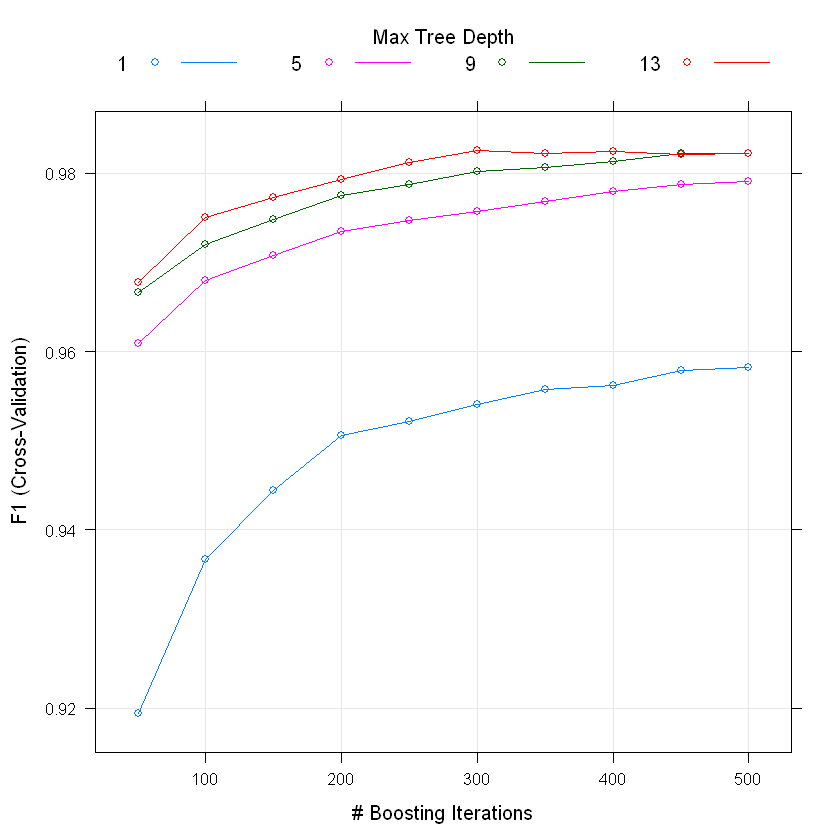

In [13]:
plot(model_gbm)  

In [34]:
model_svm_default<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='svmRadial')
model_svm_default

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


Support Vector Machines with Radial Basis Function Kernel 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  C     F1         prec       rec        Type_I_err  Type_II_err
  0.25  0.9604534  0.9531125  0.9679183  0.03540864  0.02385537 
  0.50  0.9639362  0.9550975  0.9729535  0.03401797  0.02011125 
  1.00  0.9661878  0.9561862  0.9764063  0.03326915  0.01754386 

Tuning parameter 'sigma' was held constant at a value of 0.07060089
F1 was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.07060089 and C = 1.

In [32]:
svm_grid <-  expand.grid(sigma= 2^c(-25, -20, -15,-10, -5, 0), C= 2^c(0:5))
model_svm<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='svmRadial',tuneGrid = svm_grid)
model_svm

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


Support Vector Machines with Radial Basis Function Kernel 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  sigma         C   F1         prec       rec        Type_I_err  Type_II_err 
  2.980232e-08   1  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  2.980232e-08   2  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  2.980232e-08   4  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  2.980232e-08   8  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  2.980232e-08  16  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  2.980232e-08  32  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  9.536743e-07   1  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  9.536743e-07   2  0.8529358  0.7435815  1.0000000  0.25641849  0.0000000000
  9.536743e-07   4  0.8529358  0.7435815

Best F1 score: 0.969

In [33]:
rda_grid <-  expand.grid(gamma = (0:4)/4, lambda = 3/4)
model_rda<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='rda',,tuneGrid = rda_grid)
model_rda

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


Regularized Discriminant Analysis 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  gamma  F1         prec       rec        Type_I_err  Type_II_err
  0.00   0.9364976  0.9130746  0.9611567  0.06803594  0.02888318 
  0.25   0.5666365  0.6615868  0.6594735  0.17051776  0.25320924 
  0.50   0.5654894  0.7628793  0.6486836  0.16880616  0.26123235 
  0.75   0.5688843  0.7895242  0.6443677  0.16420625  0.26444159 
  1.00   0.8392086  0.7841455  0.9036110  0.18602910  0.07167309 

Tuning parameter 'lambda' was held constant at a value of 0.75
F1 was used to select the optimal model using the largest value.
The final values used for the model were gamma = 0 and lambda = 0.75.

Best F1 score: 0.936

In [149]:
library(randomForest)
rf_grid<-expand.grid(mtry=seq(from =1, to = 25, by = 2))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_rf<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, ntree=200,method='rf',tuneGrid = rf_grid)
model_rf

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


Random Forest 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  mtry  F1         prec       rec        Type_I_err  Type_II_err
   1    0.9117473  0.8402520  0.9965473  0.14088575  0.002567394
   3    0.9773350  0.9686526  0.9861890  0.02374840  0.010269576
   5    0.9829043  0.9773860  0.9884909  0.01700899  0.008557980
   7    0.9841632  0.9804476  0.9879154  0.01465554  0.008985879
   9    0.9841539  0.9808546  0.9874838  0.01433462  0.009306804
  11    0.9839554  0.9797512  0.9882031  0.01519042  0.008771930
  13    0.9844402  0.9812791  0.9876277  0.01401369  0.009199829
  15    0.9830233  0.9788967  0.9871961  0.01583226  0.009520753
  17    0.9829485  0.9790289  0.9869084  0.01572529  0.009734703
  19    0.9827284  0.9790178  0.9864768  0.01572529  0.010055627
  21    0.9826611  0.9787398  0.9866206  0.01593924  0.009948652
  23  

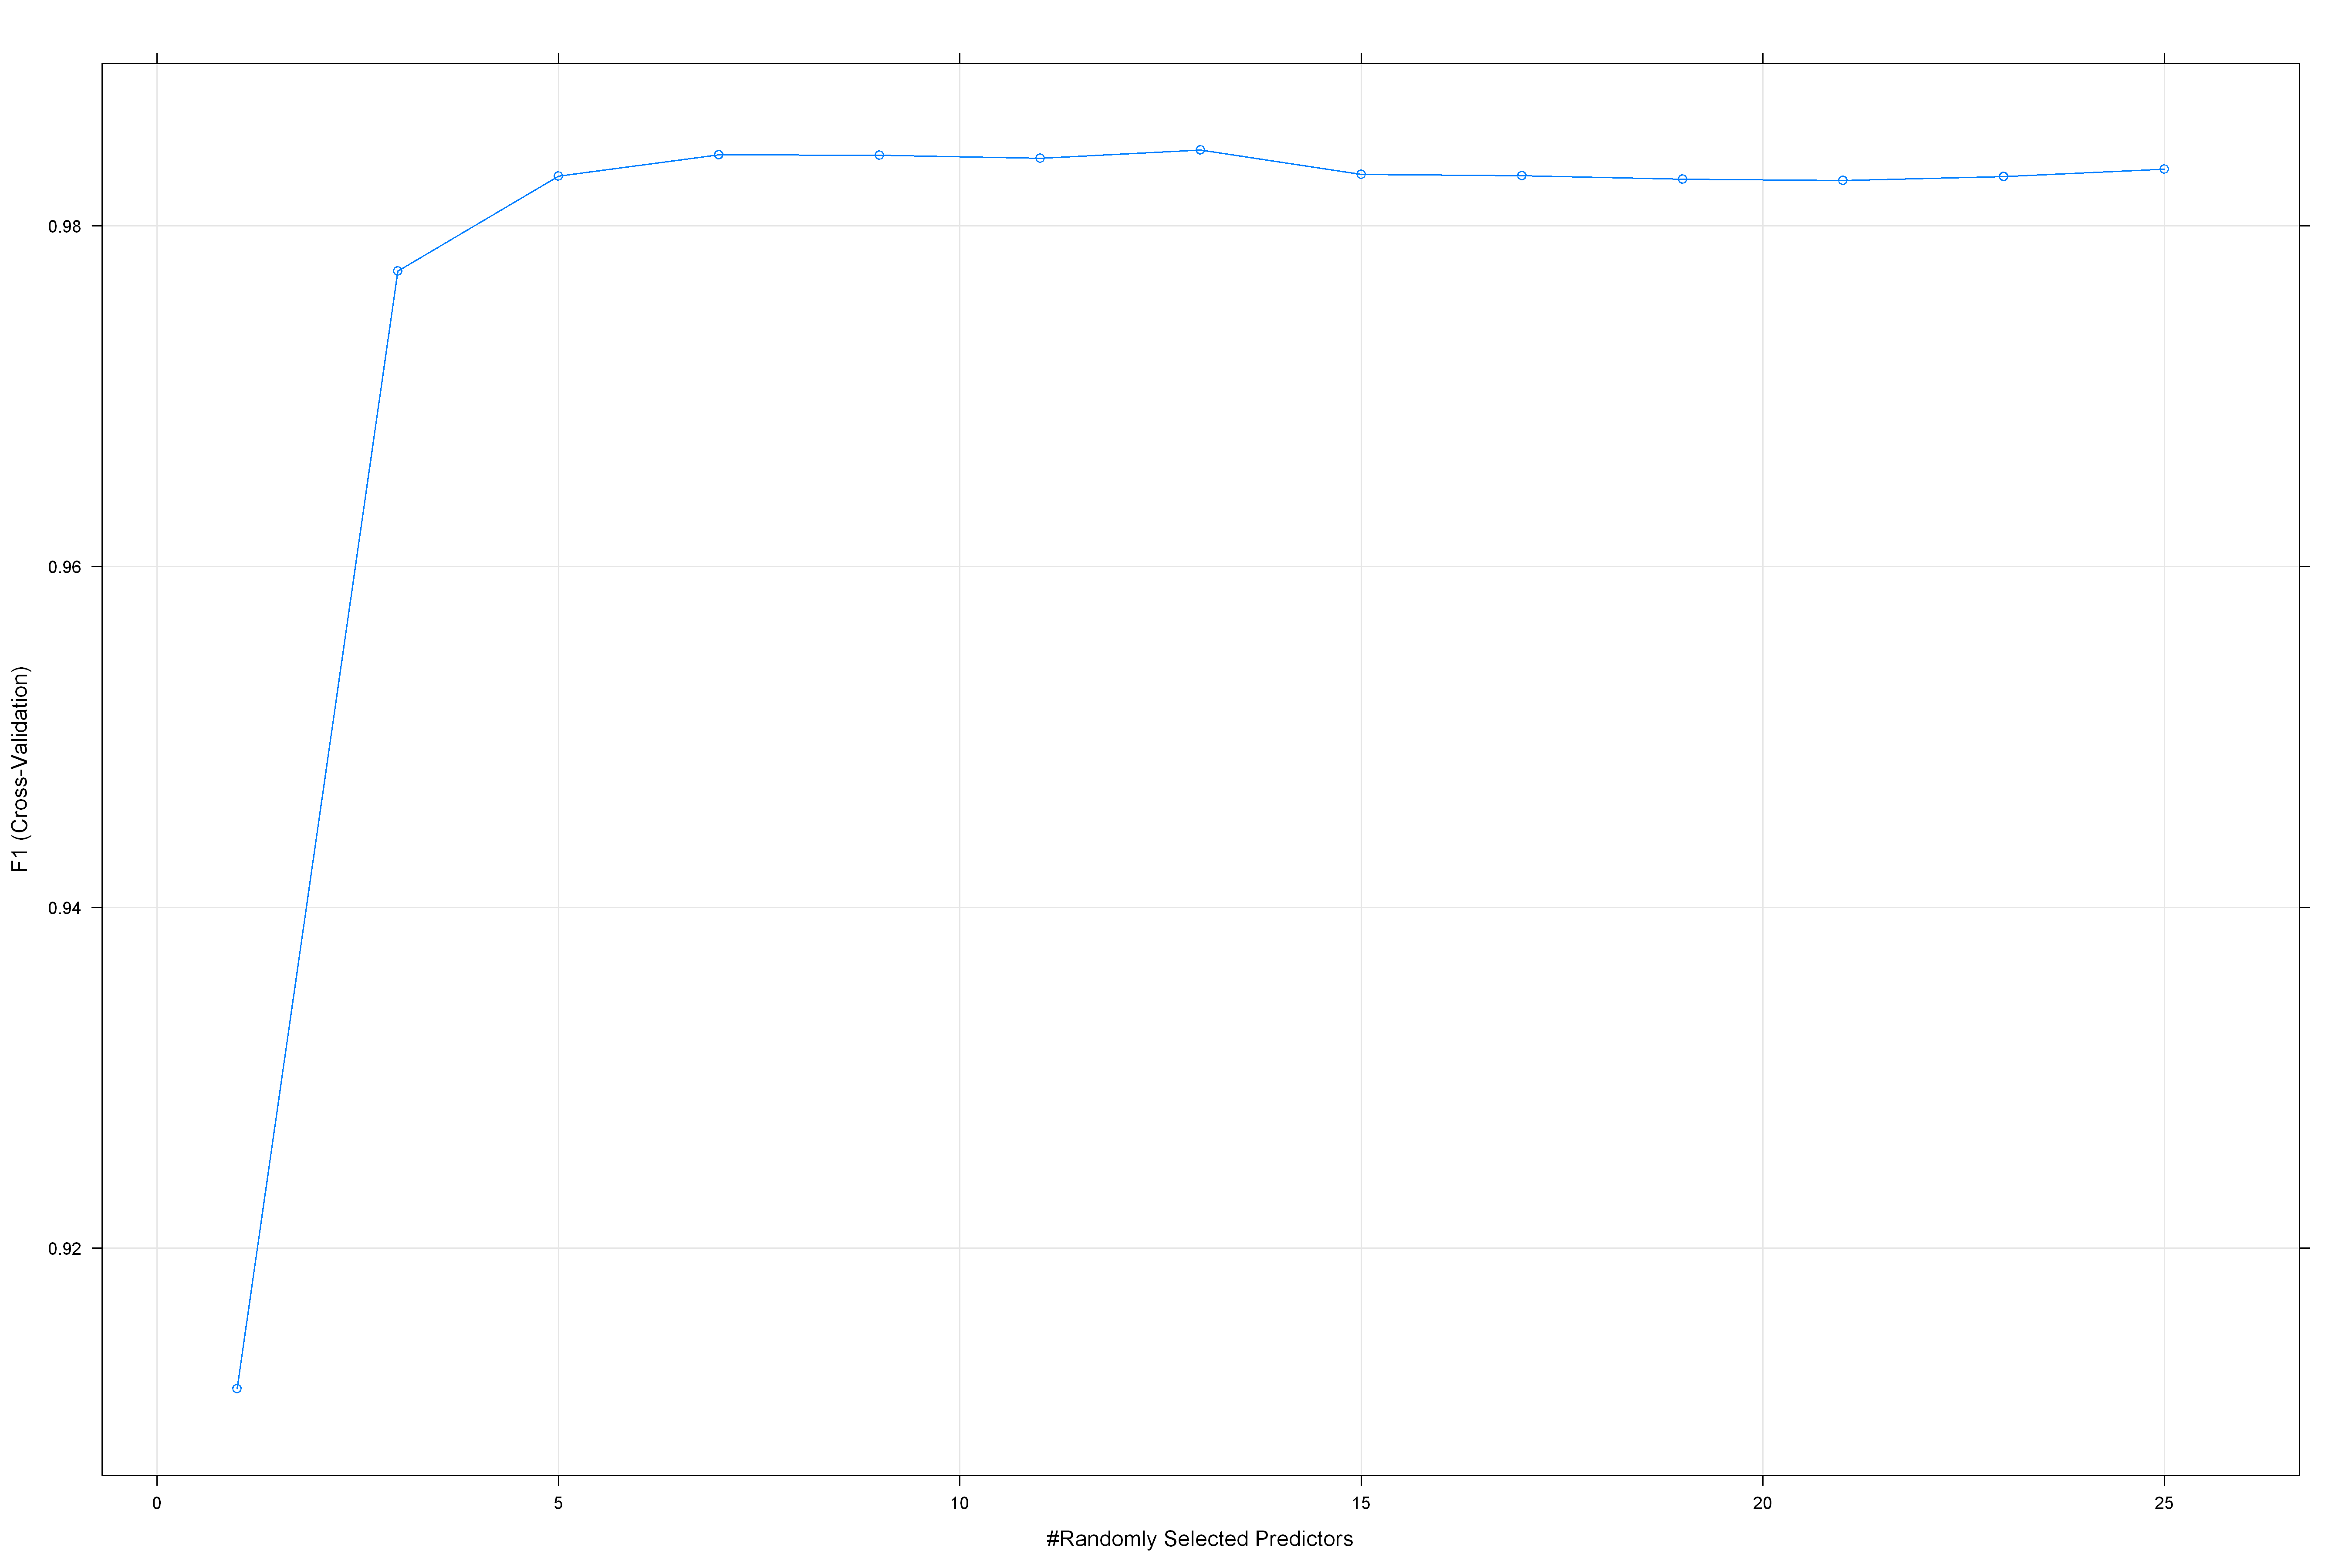

In [150]:
plot(model_rf)

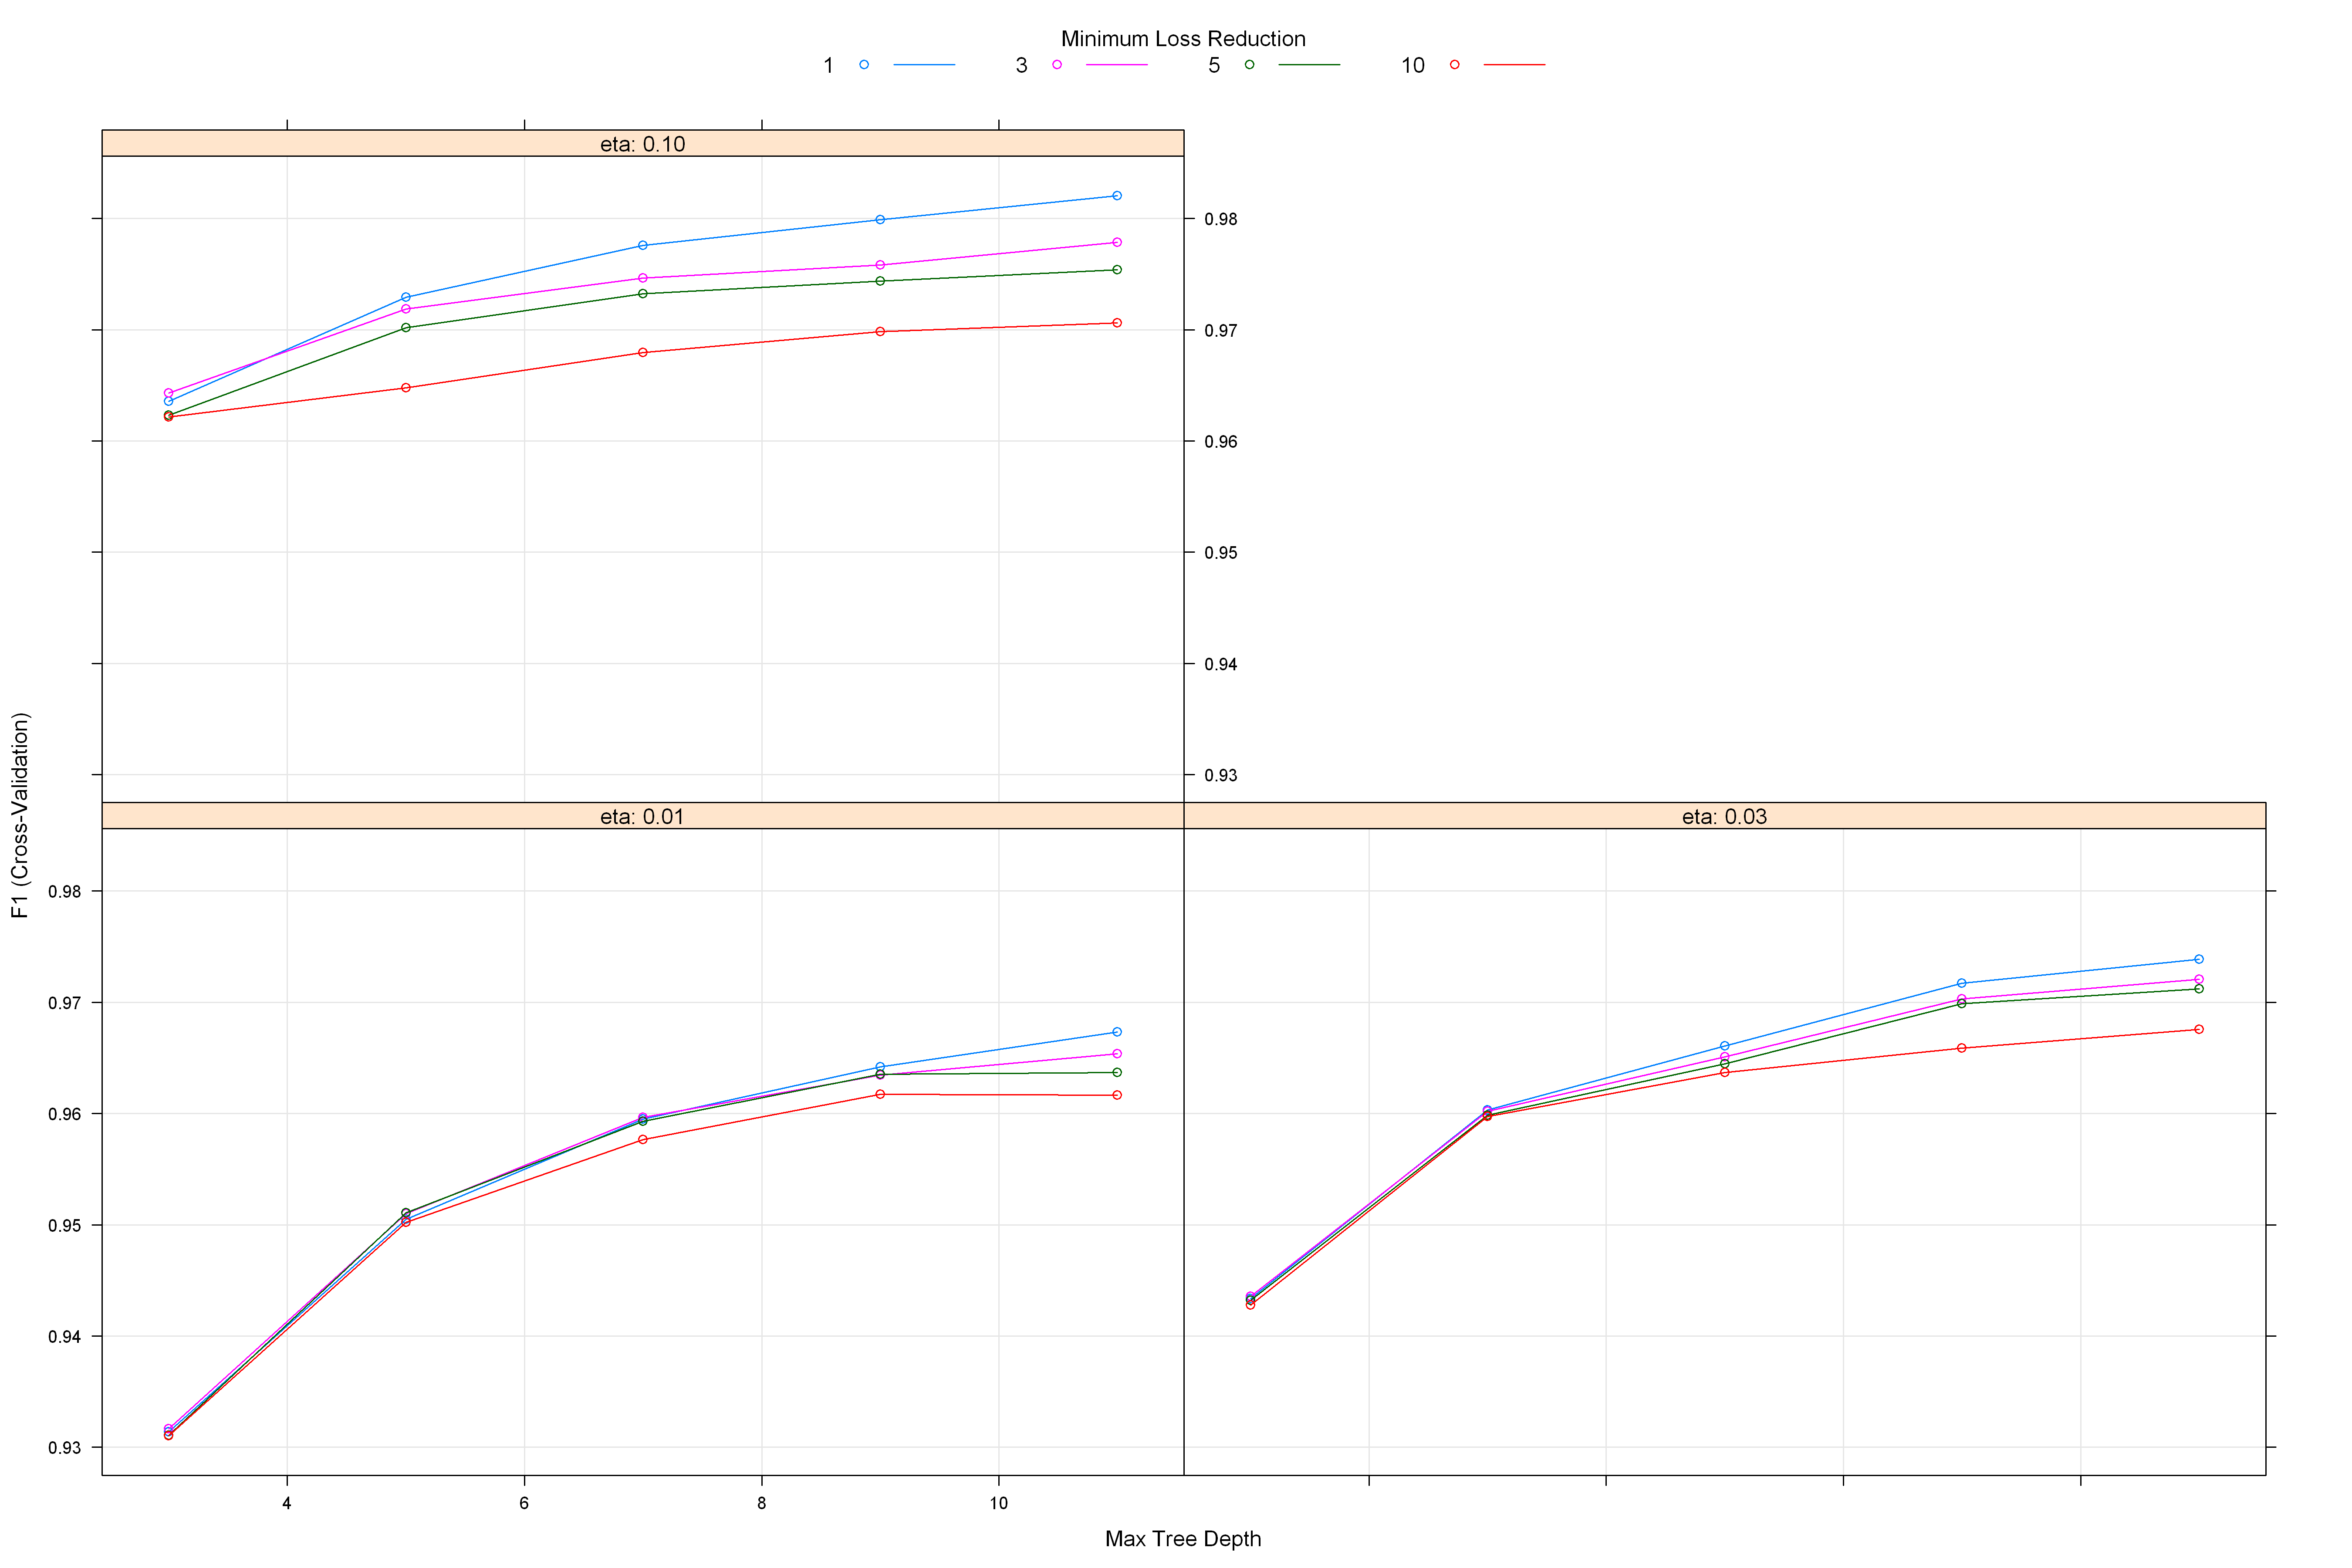

In [148]:
plot(model_xgb)

Best F1 score: 0.981

In [114]:
library(xgboost)
xgb_grid<-expand.grid(nrounds = 100, max_depth = c(3,5,7,9,11), eta = c(0.01,0.03,0.1), gamma=c(1,3,5,10), colsample_bytree=1, min_child_weight=1, subsample=1)
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_xgb<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='xgbTree',tuneGrid = xgb_grid)
model_xgb

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


eXtreme Gradient Boosting 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  eta   max_depth  gamma  F1         prec       rec        Type_I_err
  0.01   3          1     0.9313857  0.8895093  0.9774133  0.09028669
  0.01   3          3     0.9316600  0.8897700  0.9777011  0.09007274
  0.01   3          5     0.9310845  0.8887164  0.9777011  0.09103552
  0.01   3         10     0.9310560  0.8890201  0.9772695  0.09071459
  0.01   5          1     0.9504911  0.9259203  0.9764063  0.05808729
  0.01   5          3     0.9509920  0.9262261  0.9771256  0.05787334
  0.01   5          5     0.9510593  0.9263498  0.9771256  0.05776637
  0.01   5         10     0.9502090  0.9244799  0.9774133  0.05937099
  0.01   7          1     0.9594990  0.9450793  0.9743922  0.04214805
  0.01   7          3     0.9596473  0.9449528  0.9748238  0.04225503
  0.

Best F1 score: 0.982

In [105]:
library(ada)
bct_grid<-expand.grid(iter= 100 ,maxdepth= c(3,5,12,30) , nu= c(1,2,3))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_btc<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='ada',tuneGrid = bct_grid)
model_btc

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


Boosted Classification Trees 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  nu  maxdepth  F1         prec       rec        Type_I_err  Type_II_err
  1    3        0.9712446  0.9639098  0.9787081  0.02727856  0.015832264
  1    5        0.9802936  0.9733578  0.9873400  0.02011125  0.009413778
  1   12        0.9797165  0.9695896  0.9900734  0.02310655  0.007381258
  1   30        0.9792518  0.9678672  0.9909366  0.02449722  0.006739409
  2    3        0.9451364  0.9545393  0.9359804  0.03316217  0.047603766
  2    5        0.9712190  0.9668022  0.9756870  0.02492512  0.018078733
  2   12        0.9715941  0.9640292  0.9792836  0.02717159  0.015404365
  2   30        0.9702893  0.9611819  0.9795713  0.02941806  0.015190415
  3    3        0.8236309  0.8942476  0.7663646  0.06718015  0.173727000
  3    5        0.8336036  0.9079662  0.7

In [108]:
library(deepboost)
db_grid<-expand.grid(num_iter= 100 ,tree_depth= c(3,5,12,30) , beta= 0, lambda= 0.05, loss_type ="l" )
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_db<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='deepboost',tuneGrid = db_grid)
model_db

Warning message:
"package 'deepboost' was built under R version 3.6.3"
Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."
Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.11104, avg tree size: 15, num trees: 1
Iteration: 2, error: 0.11104, avg tree size: 14, num trees: 2
Iteration: 3, error: 0.095154, avg tree size: 14.3333, num trees: 3
Iteration: 4, error: 0.0956354, avg tree size: 13.5, num trees: 4
Iteration: 5, error: 0.0896983, avg tree size: 13.4, num trees: 5
Iteration: 6, error: 0.0815148, avg tree size: 13, num trees: 6
Iteration: 7, error: 0.0787869, avg tree size: 13, num trees: 7
Iteration: 8, error: 0.0744544, avg tree size: 12.5, num trees: 8
Iteration: 9, error: 0.0706033, avg tree size: 11.8889, num trees: 9
Iteration: 10, error: 0.0720475, avg tree size: 12, num trees: 10
Iteration: 11, error: 0.0715661, avg tree size: 12, num trees: 10
Iteration: 12, error: 0.0712452, avg tree size: 12, num trees: 10
Iteration: 13, error: 0.0659499, avg tree size: 11.7273, num trees: 11
Iteration: 14, error: 0.0699615, avg tree size: 11.8333, num trees: 12
Iteration: 15, error: 0.0643453, avg tree size: 11.8333, num trees: 12
It

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0893774, avg tree size: 31, num trees: 1
Iteration: 2, error: 0.0893774, avg tree size: 30, num trees: 2
Iteration: 3, error: 0.0678755, avg tree size: 29.6667, num trees: 3
Iteration: 4, error: 0.0678755, avg tree size: 27.5, num trees: 4
Iteration: 5, error: 0.0532734, avg tree size: 27, num trees: 5
Iteration: 6, error: 0.0556804, avg tree size: 25.3333, num trees: 6
Iteration: 7, error: 0.0503851, avg tree size: 23.8571, num trees: 7
Iteration: 8, error: 0.0539153, avg tree size: 23.25, num trees: 8
Iteration: 9, error: 0.0487805, avg tree size: 23.2222, num trees: 9
Iteration: 10, error: 0.0484596, avg tree size: 24.6, num trees: 10
Iteration: 11, error: 0.0476573, avg tree size: 24.0909, num trees: 11
Iteration: 12, error: 0.0473363, avg tree size: 24, num trees: 12
Iteration: 13, error: 0.0462131, avg tree size: 23.6154, num trees: 13
Iteration: 14, error: 0.0460526, avg tree size: 23.6154, num trees: 13
Iteration: 15, error: 0.0457317, avg tree size: 23.5

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0617779, avg tree size: 63, num trees: 1
Iteration: 2, error: 0.0617779, avg tree size: 54, num trees: 2
Iteration: 3, error: 0.0558408, avg tree size: 49, num trees: 3
Iteration: 4, error: 0.0547176, avg tree size: 47, num trees: 4
Iteration: 5, error: 0.0491014, avg tree size: 41.4, num trees: 5
Iteration: 6, error: 0.0482991, avg tree size: 40, num trees: 6
Iteration: 7, error: 0.0482991, avg tree size: 37.8571, num trees: 7
Iteration: 8, error: 0.0396341, avg tree size: 36.5, num trees: 8
Iteration: 9, error: 0.0401155, avg tree size: 35.8889, num trees: 9
Iteration: 10, error: 0.0388318, avg tree size: 35.8889, num trees: 9
Iteration: 11, error: 0.0391528, avg tree size: 34.6, num trees: 10
Iteration: 12, error: 0.0378691, avg tree size: 34.8182, num trees: 11
Iteration: 13, error: 0.0386714, avg tree size: 34.8182, num trees: 11
Iteration: 14, error: 0.0362644, avg tree size: 35.1667, num trees: 12
Iteration: 15, error: 0.0359435, avg tree size: 34.3846, nu

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0606547, avg tree size: 67, num trees: 1
Iteration: 2, error: 0.0606547, avg tree size: 59, num trees: 2
Iteration: 3, error: 0.0511874, avg tree size: 53, num trees: 3
Iteration: 4, error: 0.0508665, avg tree size: 50, num trees: 4
Iteration: 5, error: 0.0441271, avg tree size: 43.4, num trees: 5
Iteration: 6, error: 0.0442875, avg tree size: 42.6667, num trees: 6
Iteration: 7, error: 0.0430038, avg tree size: 40.7143, num trees: 7
Iteration: 8, error: 0.0385109, avg tree size: 38.5, num trees: 8
Iteration: 9, error: 0.0383504, avg tree size: 38.5, num trees: 8
Iteration: 10, error: 0.0373877, avg tree size: 38.3333, num trees: 9
Iteration: 11, error: 0.0348203, avg tree size: 38.4, num trees: 10
Iteration: 12, error: 0.0343389, avg tree size: 38.4, num trees: 10
Iteration: 13, error: 0.0344994, avg tree size: 38.4, num trees: 10
Iteration: 14, error: 0.0349807, avg tree size: 38.4, num trees: 10
Iteration: 15, error: 0.0349807, avg tree size: 38.4, num trees: 1

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.112003, avg tree size: 15, num trees: 1
Iteration: 2, error: 0.112003, avg tree size: 14, num trees: 2
Iteration: 3, error: 0.101733, avg tree size: 14.3333, num trees: 3
Iteration: 4, error: 0.0980424, avg tree size: 13.5, num trees: 4
Iteration: 5, error: 0.08681, avg tree size: 13.8, num trees: 5
Iteration: 6, error: 0.0767009, avg tree size: 13.3333, num trees: 6
Iteration: 7, error: 0.0786264, avg tree size: 13.5714, num trees: 7
Iteration: 8, error: 0.073973, avg tree size: 13, num trees: 8
Iteration: 9, error: 0.0731707, avg tree size: 12.3333, num trees: 9
Iteration: 10, error: 0.0693196, avg tree size: 12, num trees: 10
Iteration: 11, error: 0.0675546, avg tree size: 12.2727, num trees: 11
Iteration: 12, error: 0.0661104, avg tree size: 12, num trees: 12
Iteration: 13, error: 0.0662709, avg tree size: 12.0769, num trees: 13
Iteration: 14, error: 0.0689987, avg tree size: 12.0769, num trees: 13
Iteration: 15, error: 0.0673941, avg tree size: 12.0769, num 

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.093068, avg tree size: 25, num trees: 1
Iteration: 2, error: 0.093068, avg tree size: 26, num trees: 2
Iteration: 3, error: 0.0792683, avg tree size: 27.6667, num trees: 3
Iteration: 4, error: 0.0741335, avg tree size: 26, num trees: 4
Iteration: 5, error: 0.067715, avg tree size: 25.4, num trees: 5
Iteration: 6, error: 0.0555199, avg tree size: 24.6667, num trees: 6
Iteration: 7, error: 0.0553594, avg tree size: 23.2857, num trees: 7
Iteration: 8, error: 0.054878, avg tree size: 22.5, num trees: 8
Iteration: 9, error: 0.0521502, avg tree size: 23.2222, num trees: 9
Iteration: 10, error: 0.0474968, avg tree size: 22.4, num trees: 10
Iteration: 11, error: 0.0505456, avg tree size: 22.6364, num trees: 11
Iteration: 12, error: 0.0484596, avg tree size: 22.8333, num trees: 12
Iteration: 13, error: 0.0474968, avg tree size: 23.3077, num trees: 13
Iteration: 14, error: 0.0466945, avg tree size: 22.5714, num trees: 14
Iteration: 15, error: 0.046534, avg tree size: 22.57

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0637035, avg tree size: 59, num trees: 1
Iteration: 2, error: 0.0637035, avg tree size: 51, num trees: 2
Iteration: 3, error: 0.0482991, avg tree size: 49, num trees: 3
Iteration: 4, error: 0.0482991, avg tree size: 46, num trees: 4
Iteration: 5, error: 0.0479782, avg tree size: 41, num trees: 5
Iteration: 6, error: 0.0468549, avg tree size: 41, num trees: 6
Iteration: 7, error: 0.0471759, avg tree size: 37, num trees: 7
Iteration: 8, error: 0.0393132, avg tree size: 35.75, num trees: 8
Iteration: 9, error: 0.0380295, avg tree size: 36.5556, num trees: 9
Iteration: 10, error: 0.03819, avg tree size: 36.5556, num trees: 9
Iteration: 11, error: 0.0377086, avg tree size: 36.2, num trees: 10
Iteration: 12, error: 0.0372272, avg tree size: 35.3636, num trees: 11
Iteration: 13, error: 0.0377086, avg tree size: 35.3636, num trees: 11
Iteration: 14, error: 0.0378691, avg tree size: 35.3636, num trees: 11
Iteration: 15, error: 0.0377086, avg tree size: 35.3636, num trees:

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0632221, avg tree size: 61, num trees: 1
Iteration: 2, error: 0.0632221, avg tree size: 56, num trees: 2
Iteration: 3, error: 0.04862, avg tree size: 51.6667, num trees: 3
Iteration: 4, error: 0.04862, avg tree size: 47.5, num trees: 4
Iteration: 5, error: 0.0482991, avg tree size: 41.4, num trees: 5
Iteration: 6, error: 0.0474968, avg tree size: 40, num trees: 6
Iteration: 7, error: 0.0457317, avg tree size: 37, num trees: 7
Iteration: 8, error: 0.0393132, avg tree size: 35.5, num trees: 8
Iteration: 9, error: 0.0383504, avg tree size: 35, num trees: 9
Iteration: 10, error: 0.0380295, avg tree size: 35, num trees: 9
Iteration: 11, error: 0.0370668, avg tree size: 35, num trees: 10
Iteration: 12, error: 0.0378691, avg tree size: 35, num trees: 10
Iteration: 13, error: 0.0346598, avg tree size: 36.6364, num trees: 11
Iteration: 14, error: 0.0369063, avg tree size: 36.6364, num trees: 11
Iteration: 15, error: 0.0351412, avg tree size: 37, num trees: 12
Iteration: 1

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.113286, avg tree size: 15, num trees: 1
Iteration: 2, error: 0.113286, avg tree size: 15, num trees: 2
Iteration: 3, error: 0.105103, avg tree size: 14.3333, num trees: 3
Iteration: 4, error: 0.0988447, avg tree size: 13.5, num trees: 4
Iteration: 5, error: 0.0924262, avg tree size: 13.8, num trees: 5
Iteration: 6, error: 0.0885751, avg tree size: 13.6667, num trees: 6
Iteration: 7, error: 0.0832798, avg tree size: 13, num trees: 7
Iteration: 8, error: 0.0773427, avg tree size: 12.5, num trees: 8
Iteration: 9, error: 0.0768614, avg tree size: 12.3333, num trees: 9
Iteration: 10, error: 0.0750963, avg tree size: 12.3333, num trees: 9
Iteration: 11, error: 0.0717266, avg tree size: 11.8, num trees: 10
Iteration: 12, error: 0.0707638, avg tree size: 11.9091, num trees: 11
Iteration: 13, error: 0.0688383, avg tree size: 11.9091, num trees: 11
Iteration: 14, error: 0.0662709, avg tree size: 11.5, num trees: 12
Iteration: 15, error: 0.0670732, avg tree size: 11.6154, n

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0932285, avg tree size: 25, num trees: 1
Iteration: 2, error: 0.0932285, avg tree size: 27, num trees: 2
Iteration: 3, error: 0.0738126, avg tree size: 25.6667, num trees: 3
Iteration: 4, error: 0.0720475, avg tree size: 24.5, num trees: 4
Iteration: 5, error: 0.0717266, avg tree size: 25.4, num trees: 5
Iteration: 6, error: 0.0620988, avg tree size: 24.6667, num trees: 6
Iteration: 7, error: 0.0608151, avg tree size: 25, num trees: 7
Iteration: 8, error: 0.0568036, avg tree size: 25, num trees: 8
Iteration: 9, error: 0.0564827, avg tree size: 24.3333, num trees: 9
Iteration: 10, error: 0.055199, avg tree size: 25.2, num trees: 10
Iteration: 11, error: 0.0564827, avg tree size: 25.2, num trees: 10
Iteration: 12, error: 0.054878, avg tree size: 24.6364, num trees: 11
Iteration: 13, error: 0.0500642, avg tree size: 24.8333, num trees: 12
Iteration: 14, error: 0.0515083, avg tree size: 24.8333, num trees: 12
Iteration: 15, error: 0.0479782, avg tree size: 23.9231, n

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0659499, avg tree size: 51, num trees: 1
Iteration: 2, error: 0.0659499, avg tree size: 54, num trees: 2
Iteration: 3, error: 0.0592105, avg tree size: 49, num trees: 3
Iteration: 4, error: 0.0580873, avg tree size: 44, num trees: 4
Iteration: 5, error: 0.0574454, avg tree size: 43, num trees: 5
Iteration: 6, error: 0.0555199, avg tree size: 39.6667, num trees: 6
Iteration: 7, error: 0.0460526, avg tree size: 38.7143, num trees: 7
Iteration: 8, error: 0.0442875, avg tree size: 38.5, num trees: 8
Iteration: 9, error: 0.042362, avg tree size: 39.6667, num trees: 9
Iteration: 10, error: 0.0418806, avg tree size: 39.6667, num trees: 9
Iteration: 11, error: 0.0397946, avg tree size: 40.2, num trees: 10
Iteration: 12, error: 0.0401155, avg tree size: 40.2, num trees: 10
Iteration: 13, error: 0.0394737, avg tree size: 39.7273, num trees: 11
Iteration: 14, error: 0.0394737, avg tree size: 39.7273, num trees: 11
Iteration: 15, error: 0.0357831, avg tree size: 38.6667, num

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0654685, avg tree size: 53, num trees: 1
Iteration: 2, error: 0.0654685, avg tree size: 56, num trees: 2
Iteration: 3, error: 0.0571245, avg tree size: 53, num trees: 3
Iteration: 4, error: 0.0566431, avg tree size: 48.5, num trees: 4
Iteration: 5, error: 0.0571245, avg tree size: 42.6, num trees: 5
Iteration: 6, error: 0.0426829, avg tree size: 41.6667, num trees: 6
Iteration: 7, error: 0.0439666, avg tree size: 41.2857, num trees: 7
Iteration: 8, error: 0.0433248, avg tree size: 38.5, num trees: 8
Iteration: 9, error: 0.0412388, avg tree size: 37.4444, num trees: 9
Iteration: 10, error: 0.0397946, avg tree size: 37.4444, num trees: 9
Iteration: 11, error: 0.0391528, avg tree size: 37.4, num trees: 10
Iteration: 12, error: 0.0377086, avg tree size: 37.5455, num trees: 11
Iteration: 13, error: 0.0377086, avg tree size: 37.5455, num trees: 11
Iteration: 14, error: 0.0356226, avg tree size: 37.3333, num trees: 12
Iteration: 15, error: 0.0349807, avg tree size: 37.3

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


Iteration: 1, error: 0.0653616, avg tree size: 53, num trees: 1
Iteration: 2, error: 0.0653616, avg tree size: 50, num trees: 2
Iteration: 3, error: 0.0523107, avg tree size: 49.6667, num trees: 3
Iteration: 4, error: 0.0523107, avg tree size: 48, num trees: 4
Iteration: 5, error: 0.0504921, avg tree size: 41.4, num trees: 5
Iteration: 6, error: 0.0496363, avg tree size: 41.3333, num trees: 6
Iteration: 7, error: 0.0400086, avg tree size: 39, num trees: 7
Iteration: 8, error: 0.0428969, avg tree size: 36.75, num trees: 8
Iteration: 9, error: 0.0393667, avg tree size: 38.1111, num trees: 9
Iteration: 10, error: 0.038297, avg tree size: 39.2, num trees: 10
Iteration: 11, error: 0.03819, avg tree size: 39.2, num trees: 10
Iteration: 12, error: 0.03819, avg tree size: 40.4545, num trees: 11
Iteration: 13, error: 0.0370133, avg tree size: 40.6667, num trees: 12
Iteration: 14, error: 0.0366923, avg tree size: 40.6667, num trees: 12
Iteration: 15, error: 0.0366923, avg tree size: 41.3077, num

DeepBoost 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  tree_depth  F1         prec       rec        Type_I_err  Type_II_err
   3          0.9606728  0.9466621  0.9751115  0.04086436  0.01850663 
   5          0.9690022  0.9600528  0.9781326  0.03027386  0.01626016 
  12          0.9738719  0.9667057  0.9811538  0.02513907  0.01401369 
  30          0.9729984  0.9663801  0.9797151  0.02535302  0.01508344 

Tuning parameter 'num_iter' was held constant at a value of 100
 parameter 'lambda' was held constant at a value of 0.05
Tuning
 parameter 'loss_type' was held constant at a value of l
F1 was used to select the optimal model using the largest value.
The final values used for the model were num_iter = 100, tree_depth = 12,
 beta = 0, lambda = 0.05 and loss_type = l.

## Final Model and Feature Importance <a name="fi"></a>

In [16]:
xgb_grid_pick<-expand.grid(nrounds = 100, max_depth = 11, eta = 0.1, gamma=1, colsample_bytree=1, min_child_weight=1, subsample=1)
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_xgb_pick<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='xgbTree',tuneGrid = xgb_grid_pick)
model_xgb_pick

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."


eXtreme Gradient Boosting 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results:

  F1         prec       rec        Type_I_err  Type_II_err
  0.9818027  0.9778808  0.9857574  0.01658109  0.0105905  

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 parameter 'min_child_weight' was held constant at a value of 1

Tuning parameter 'subsample' was held constant at a value of 1

In [18]:
varImp(model_xgb_pick,scale=FALSE)

xgbTree variable importance

  only 20 most important variables shown (out of 29)

               Overall
perCaps       0.224885
forwards      0.112579
bodyCharCt    0.106334
numLines      0.090631
perHTML       0.071457
subBlanks     0.058378
isInReplyTo   0.058098
avgWordLen    0.040601
numDlr        0.034341
subExcCt      0.028985
numEnd        0.027695
hour          0.024726
isDear        0.019768
subSpamWords  0.019545
numRec        0.017305
multipartText 0.017077
isYelling     0.013465
sortedRec     0.009614
isWrote       0.005780
underscore    0.004650

,Overall
,<dbl>
isRe,113.691743
underscore,28.674350
priority,8.136926
isInReplyTo,138.065734
sortedRec,21.615298
subPunc,8.063103
multipartText,54.839479
hasImages,3.180132
isPGPsigned,2.698166


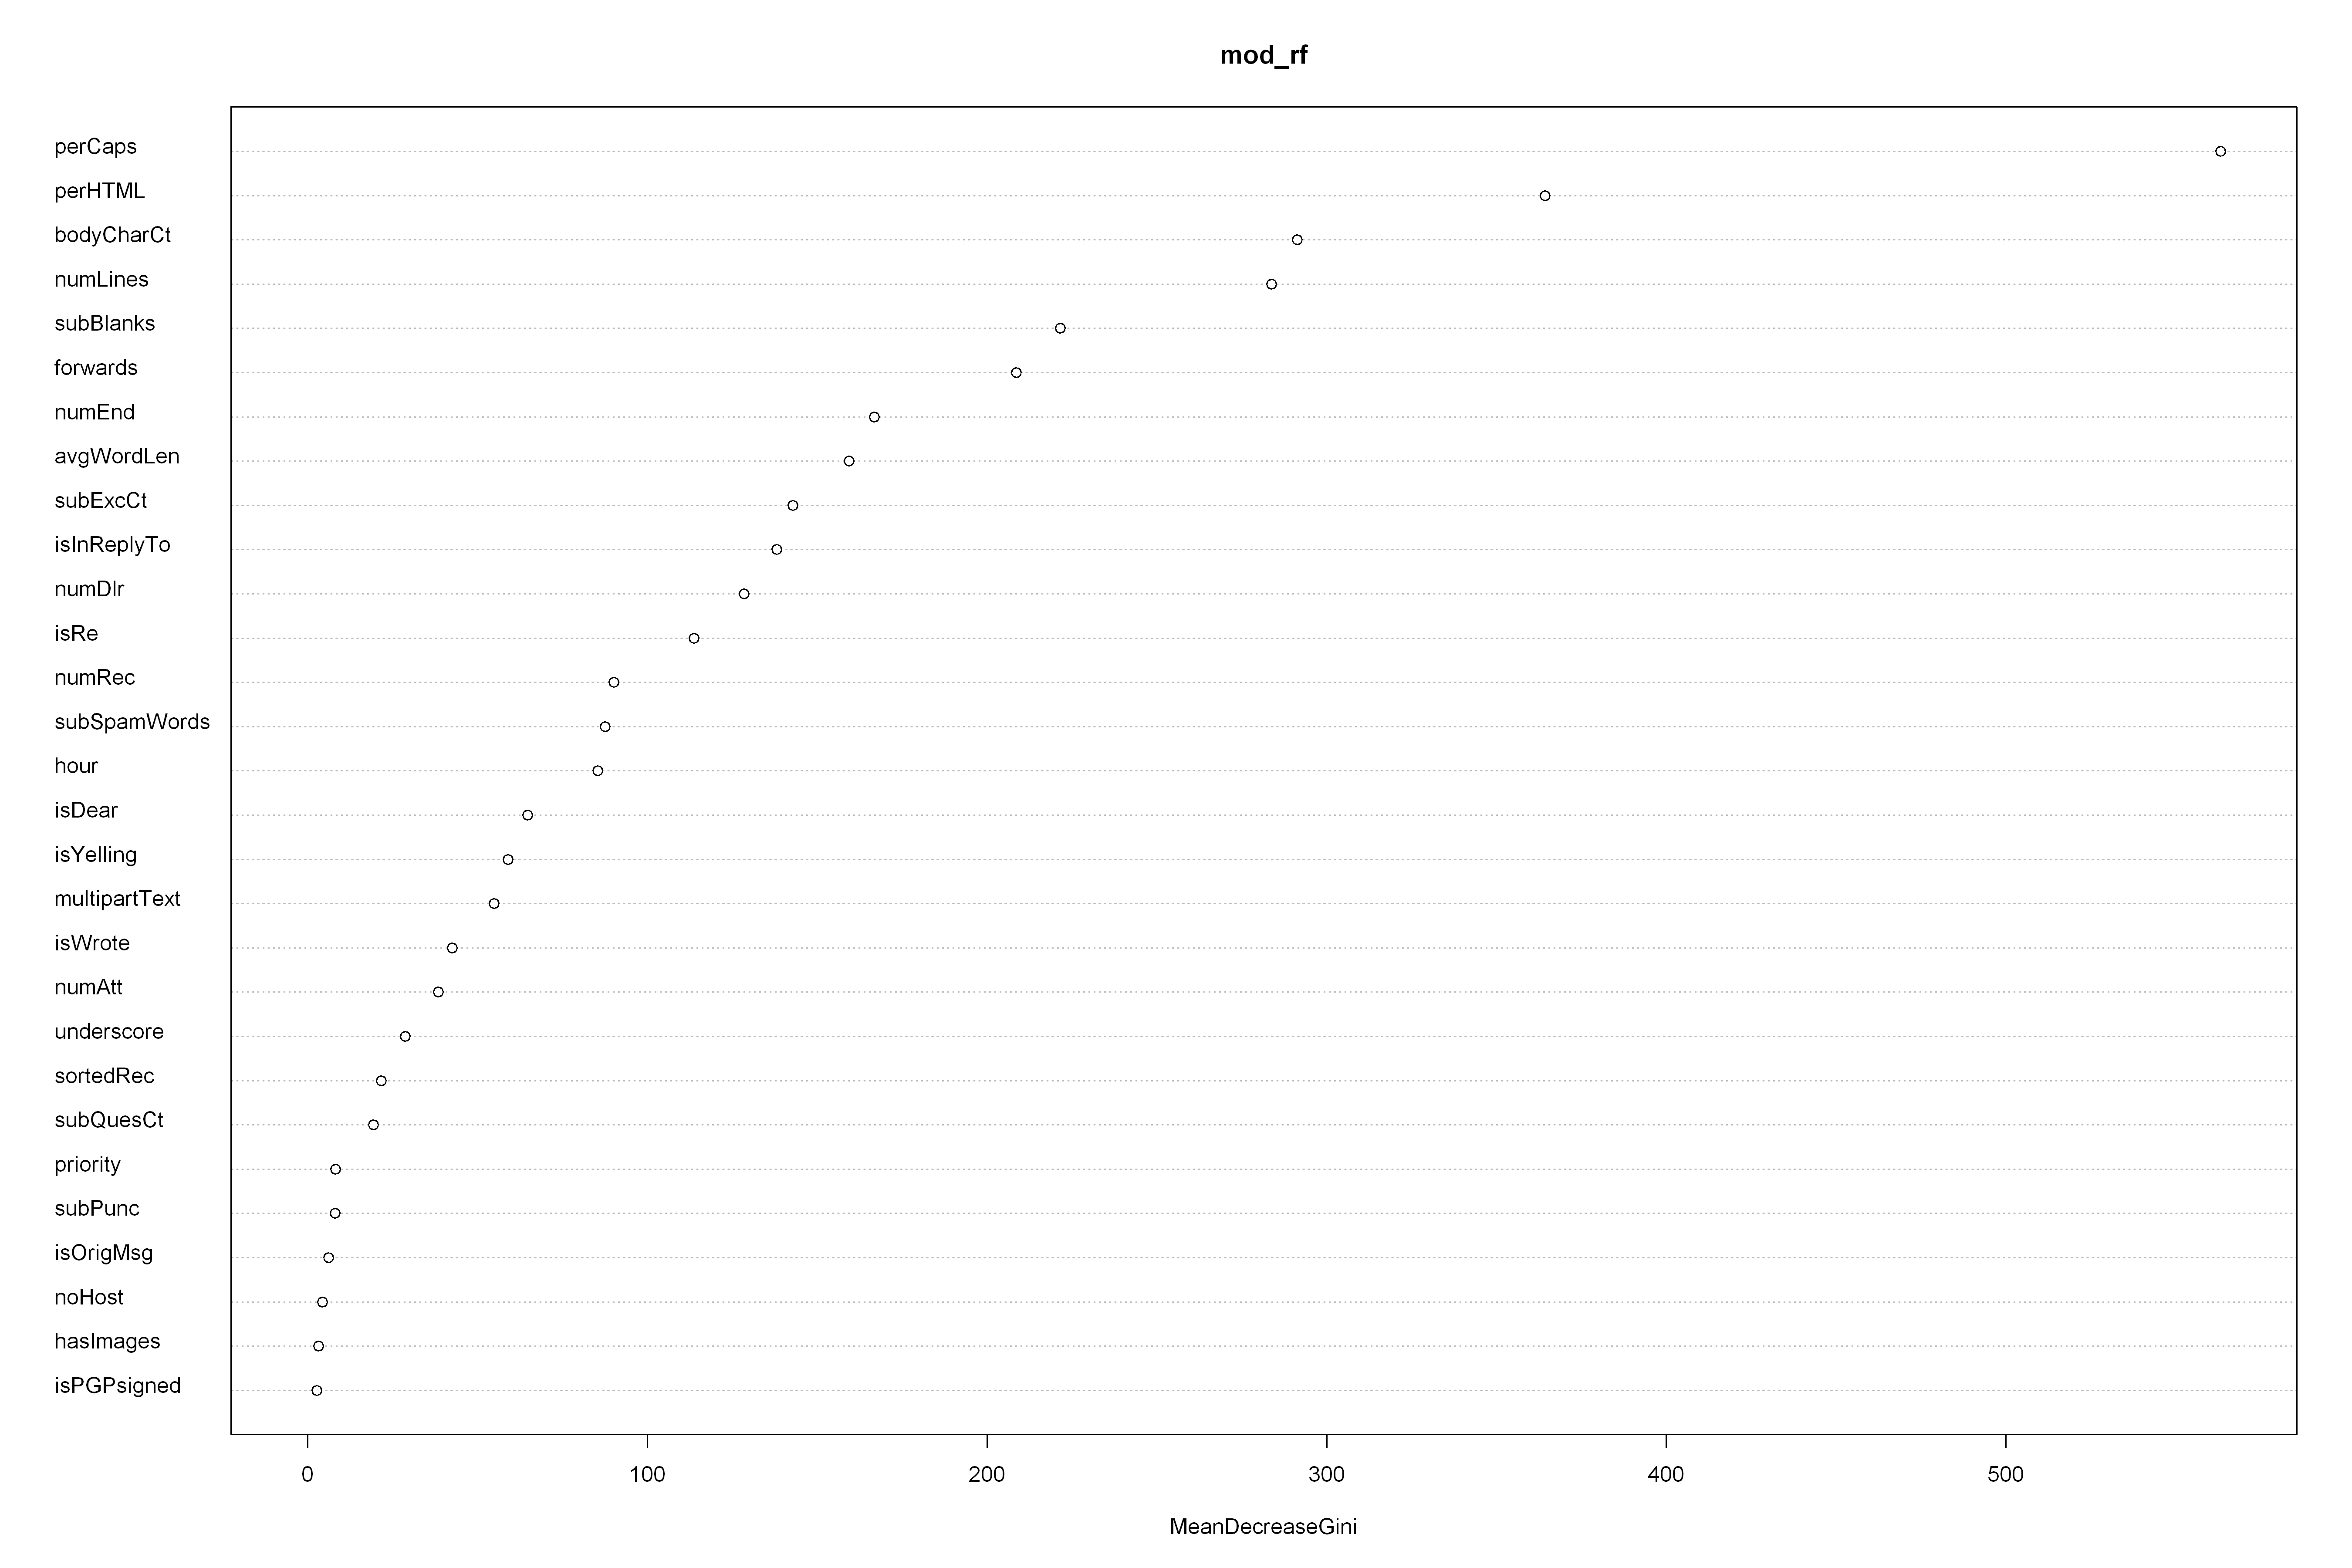

In [86]:
emailDFnum_use <- emailDFnum
emailDFnum_use["isSpam"] <- NULL
mod_rf = randomForest(emailDFnum_use,as.factor(emailDFnum$isSpam),ntree=500)
varImp(mod_rf,scale=FALSE)
options(repr.plot.width=18, repr.plot.height=12,repr.plot.res = 300)
varImpPlot(mod_rf)